#printing funcs

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import json
from PIL import Image
import requests
from io import BytesIO

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
f = open('drive/MyDrive/data/scene_graphs.json')
scene_graph_data = json.load(f)
f.close()

In [4]:
pth = 'drive/MyDrive/data/'

In [5]:
f = open(pth+'image_data.json')
image_data = json.load(f)
f.close()

In [6]:
def print_image(id):
  url = image_data[id]['url']
  response = requests.get(url, stream=True)
  img = Image.open(response.raw)

  # plt.imshow(img)
  # plt.show()
  return img

#Eval functions

In [7]:
!pip install rbo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
import rbo

In [9]:
def find_most_similar(idx, geds):
  sim_keys = [key for key in geds.keys() if idx in key]
  similarities = []
  sim_idx = []
  for key in sim_keys:
    similarities.append(geds[key][0])
    if key[0] == idx:
      sim_idx.append(key[1])
    else:
      sim_idx.append(key[0])

  sorted_sim = list(np.argsort(similarities))
  most_sim_10 = [sim_idx[sim] for sim in sorted_sim]

  return most_sim_10


def find_all(geds,idx_list):
  result = dict()
  for i in idx_list:
    result[i] = find_most_similar(i, geds)

  return result

In [10]:
#most similar to 0
def most_similar_graph(idx, emb, ten=False):
  sorted_emb = list(np.argsort(emb[idx]))
  sorted_emb.remove(idx) # remove self
  if ten:
    sim = sorted_emb[-10:]
  else:
    sim = sorted_emb
  return sim


def find_all_similar(emb, ten = False):
  size = emb.shape[0]
  similarities = []
  for i in range(size):
    sim = most_similar_graph(i, emb, ten)
    similarities.append(sim)
  return similarities

In [11]:
def hit_percentage(a, b):
  print(np.array(a).shape, np.array(b).shape)
  assert np.array(a).shape == np.array(b).shape
  intermediate_hit = []
  for i in range(len(a)):
    hits = set(a[i]).intersection(set(b[i]))
    hits_per = len(hits)/len(a[i])
    intermediate_hit.append(hits_per)

  return intermediate_hit, np.mean(intermediate_hit)

In [12]:
def score_stats(gd, sims):
  hps = dict()
  rbos = dict()
  all_hps_list = []
  all_rbo_list = []
  for k in [1,2,4,10]:
    hps[k] = list()
    rbos[k] = list()
    print('---- k = {} ----'.format(k))
    for sim in sims:
      all_hps, mean_hp = hit_percentage(np.array(sim)[:,:k], np.array(gd)[:,:k])
      hps[k].append(all_hps)
      print("Hit Percentage: {}".format(mean_hp))
      all_hps_list.append([k, mean_hp])
      all_rbos = list()
      for i in range(amount):
        all_rbos.append(rbo.RankingSimilarity(gd[i][:k], sim[i][:k]).rbo())
      
      rbos[k].append(all_rbos)
      print("Mean RBO: {}".format(np.mean(all_rbos)))
      all_rbo_list.append([k, np.mean(all_rbos)])
  return hps, rbos, all_hps_list, all_rbos

In [13]:
from sklearn.metrics import ndcg_score
import numpy as np

def format_ndcg(a, b):
  a_s = [len(a) - i for i in range(len(a))]
  score_dict = {key:val for key, val in zip(a, a_s)}
  b_s = [score_dict[i] if i in score_dict.keys() else 0 for i in b]

  return a_s, b_s

def compute_ndcg(true_rank, pred_rank, k):
  true_rank_s = []
  pred_rank_s = []
  for i,j in zip(true_rank, pred_rank):
    i_s, j_s = format_ndcg(i,j)
    true_rank_s.append(i_s)
    pred_rank_s.append(j_s)
 
  return ndcg_score(np.array(true_rank_s), np.array(pred_rank_s), k=k)

In [14]:
def format_ndcg_2(a, b):
  a_s = [0 for _ in range(len(a))]
  a_s[0] = 1
  score_dict = {key:val for key, val in zip(a, a_s)}
  b_s = [score_dict[i] if i in score_dict.keys() else 0 for i in b]

  return a_s, b_s

def compute_ndcg_2(true_rank, pred_rank, k):
  true_rank_s = []
  pred_rank_s = []
  for i,j in zip(true_rank, pred_rank):
    i_s, j_s = format_ndcg_2(i,j)
    true_rank_s.append(i_s)
    pred_rank_s.append(j_s)
 
  return ndcg_score(np.array(true_rank_s), np.array(pred_rank_s), k=k)

def precision_k(a, b, k):
  if b[0] in a[:k]:
    return 1 
  else: 
    return 0

In [15]:
def get_rank_target_class(rank, target, classes):
  rank_targets =[]
  for idx in rank:
    if classes[idx] == target:
      rank_targets.append(idx)
  return rank_targets

In [16]:
def get_rank_untargeted_class(index, rank, classes):
    rank_targets =[]
    query_class = classes[index]
    for idx in rank:
      if classes[idx] != query_class:
        rank_targets.append(idx)
    return rank_targets

#VG-dense

In [17]:
import pickle as pkl

In [18]:
new_idxs = pkl.load(open(pth+'scene500_large_idx.pkl', 'rb'))
image_ids_vg_dense = pkl.load(open(pth+'images_ids_vg_dense.pkl', 'rb'))
vg_dense_classification = pkl.load(open(pth+'vg_dense.pkl', 'rb'))

In [19]:
syn_n = pkl.load(open(pth+'syn_n500_large.pkl', 'rb'))

In [20]:
geds = pkl.load(open(pth+'ged_large500_2.pkl', 'rb'))

In [21]:
vg_dense_classification

vg_id              label  label_prob
0    2405110              igloo    0.483167
1    2397801            toyshop    0.251562
2    2411393   ice_cream_parlor    0.200570
3    2407707              motel    0.136277
4       4176           hospital    0.223278
..       ...                ...         ...
495  2411457            glacier    0.145468
496  2408678           playroom    0.247225
497  2405921     operating_room    0.262250
498  2405143  desert/vegetation    0.101315
499  2403535               wave    0.410089

[500 rows x 3 columns]

In [22]:
#list(vg_dense_classification.label)

In [23]:
len(vg_dense_classification.label.unique())

148

In [24]:
gd_rank = find_all(geds, [i[0] for i in new_idxs])

In [25]:
gd = []
for idx in new_idxs:
  gd.append(gd_rank[idx[0]])

In [26]:
class_dict =  dict()
for i in range(len(new_idxs)):
  class_dict[new_idxs[i][0]] = vg_dense_classification.iloc[[i]]['label'].item()

In [27]:
preds_gd = {}
for i in range(500):
  idx = new_idxs[i][0]
  preds_gd[idx] = get_rank_untargeted_class(idx, gd[i], class_dict)

In [28]:
confident_rows = vg_dense_classification.loc[(vg_dense_classification['label_prob'] >= 0.5)]
confident_ids = list(confident_rows['vg_id'])

In [29]:
confident_ids_to_idx = [new_idxs[image_ids_vg_dense.index(i)][0] for i in confident_ids]

In [30]:
hps_results = {}
rbo_results = {}
ndcg_results = {}
precision_results = {}
ndcg_results_2 = {}

#GCN 20K

In [31]:
import pickle as pkl

In [32]:
import numpy as np
embeddings_res = np.array(pkl.load(open(pth+'emb_gcn_20k.pkl', 'rb')))

In [33]:
from tqdm import tqdm
from scipy import spatial

comp = []
for value in tqdm(range(embeddings_res.shape[0])):
  emb_comp = []
  for i in range(embeddings_res.shape[0]):
    emb_comp.append(1 - spatial.distance.cosine(embeddings_res[value], embeddings_res[i]))

  comp.append([i/max(emb_comp) for i in emb_comp])

emb_10 = find_all_similar(np.array(comp))
for idx in range(500):
  emb_10[idx] = [new_idxs[i][0] for i in emb_10[idx] ]

emb_10 = [list(reversed(i)) for i in emb_10]

100%|██████████| 500/500 [00:44<00:00, 11.19it/s]


In [34]:
preds = {}
for i in range(500):
  idx = new_idxs[i][0]
  preds[idx] = get_rank_untargeted_class(idx, emb_10[i], class_dict)

In [35]:
amount=500

In [36]:
hps, rbos, all_hps_list, all_rbos = score_stats([preds_gd[idx[0]][:10] for idx in new_idxs], [[preds[idx[0]][:10] for idx in new_idxs]])
hps_results['GCN-20K']=all_hps_list
rbo_results['GCN-20K']=all_rbos

---- k = 1 ----
(500, 1) (500, 1)
Hit Percentage: 0.17
Mean RBO: 0.17
---- k = 2 ----
(500, 2) (500, 2)
Hit Percentage: 0.219
Mean RBO: 0.1945
---- k = 4 ----
(500, 4) (500, 4)
Hit Percentage: 0.28
Mean RBO: 0.2325833333333333
---- k = 10 ----
(500, 10) (500, 10)
Hit Percentage: 0.36119999999999997
Mean RBO: 0.293702619047619


In [37]:
ndcg_list = []
for k in [1,2,4,10]:
  print()
  print('--------{}--------'.format(k))
  for i in range(len([emb_10])):
    n = compute_ndcg([preds_gd[idx[0]][:10] for idx in new_idxs], [preds[idx[0]][:10] for idx in new_idxs], k=k)
    print(n)
    ndcg_list.append([k,n])
ndcg_results['GCN-20K'] = ndcg_list


--------1--------
0.6922

--------2--------
0.69317385775411

--------4--------
0.7135878223743533

--------10--------
0.8760762972840218


In [38]:
ndcg_list_2 = []
for k in [1,2,4,10]:
  print()
  print('--------{}--------'.format(k))
  for i in range(len([emb_10])):
    n = compute_ndcg_2([preds_gd[idx[0]][:10] for idx in new_idxs], [preds[idx[0]][:10] for idx in new_idxs], k=k)
    print(n)
    ndcg_list_2.append([k,n])
ndcg_results_2['GCN-20K'] = ndcg_list_2


--------1--------
0.2132

--------2--------
0.26835728112333584

--------4--------
0.3497190940002408

--------10--------
0.5229858319119899


In [39]:
prec_list = []
for k in [1,2,4,10]:
  print()
  print('--------{}--------'.format(k))
  for i in range(len([emb_10])):
    pr = np.mean([precision_k(b,c, k=k) for b,c in zip([preds_gd[idx[0]][:10] for idx in new_idxs], [preds[idx[0]][:10] for idx in new_idxs])])
    print(pr)
    prec_list.append([k, pr])
precision_results['GCN-20K']=prec_list


--------1--------
0.17

--------2--------
0.254

--------4--------
0.374

--------10--------
0.532


#GCN 50K

In [40]:
import numpy as np
embeddings_res = np.array(pkl.load(open(pth+'emb_gcn_50k.pkl', 'rb')))

In [41]:
from tqdm import tqdm
from scipy import spatial

comp = []
for value in tqdm(range(embeddings_res.shape[0])):
  emb_comp = []
  for i in range(embeddings_res.shape[0]):
    emb_comp.append(1 - spatial.distance.cosine(embeddings_res[value], embeddings_res[i]))

  comp.append([i/max(emb_comp) for i in emb_comp])

emb_10 = find_all_similar(np.array(comp))
for idx in range(500):
  emb_10[idx] = [new_idxs[i][0] for i in emb_10[idx] ]

emb_10 = [list(reversed(i)) for i in emb_10]

100%|██████████| 500/500 [00:28<00:00, 17.36it/s]


In [42]:
preds = {}
for i in range(500):
  idx = new_idxs[i][0]
  preds[idx] = get_rank_untargeted_class(idx, emb_10[i], class_dict)

In [43]:
amount=500

In [44]:
hps, rbos, all_hps_list, all_rbos = score_stats([preds_gd[idx[0]][:10] for idx in new_idxs], [[preds[idx[0]][:10] for idx in new_idxs]])
hps_results['GCN-50K']=all_hps_list
rbo_results['GCN-50K']=all_rbos

---- k = 1 ----
(500, 1) (500, 1)
Hit Percentage: 0.214
Mean RBO: 0.214
---- k = 2 ----
(500, 2) (500, 2)
Hit Percentage: 0.267
Mean RBO: 0.2405
---- k = 4 ----
(500, 4) (500, 4)
Hit Percentage: 0.338
Mean RBO: 0.28241666666666665
---- k = 10 ----
(500, 10) (500, 10)
Hit Percentage: 0.42619999999999997
Mean RBO: 0.34863873015873015


In [45]:
ndcg_list = []
for k in [1,2,4,10]:
  print()
  print('--------{}--------'.format(k))
  for i in range(len([emb_10])):
    n = compute_ndcg([preds_gd[idx[0]][:10] for idx in new_idxs], [preds[idx[0]][:10] for idx in new_idxs], k=k)
    print(n)
    ndcg_list.append([k,n])
ndcg_results['GCN-50K'] = ndcg_list


--------1--------
0.7234

--------2--------
0.7208003631853095

--------4--------
0.7337548070396935

--------10--------
0.885453082773869


In [46]:
ndcg_list_2 = []
for k in [1,2,4,10]:
  print()
  print('--------{}--------'.format(k))
  for i in range(len([emb_10])):
    n = compute_ndcg_2([preds_gd[idx[0]][:10] for idx in new_idxs], [preds[idx[0]][:10] for idx in new_idxs], k=k)
    print(n)
    ndcg_list_2.append([k,n])
ndcg_results_2['GCN-50K'] = ndcg_list_2


--------1--------
0.24880000000000002

--------2--------
0.30146160343143097

--------4--------
0.3791420734786235

--------10--------
0.5445690860857738


In [47]:
prec_list = []
for k in [1,2,4,10]:
  print()
  print('--------{}--------'.format(k))
  for i in range(len([emb_10])):
    pr = np.mean([precision_k(b,c, k=k) for b,c in zip([preds_gd[idx[0]][:10] for idx in new_idxs], [preds[idx[0]][:10] for idx in new_idxs])])
    print(pr)
    prec_list.append([k, pr])
precision_results['GCN-50K']=prec_list


--------1--------
0.214

--------2--------
0.338

--------4--------
0.476

--------10--------
0.614


#GCN 70K

In [48]:
import numpy as np
embeddings_res = np.array(pkl.load(open(pth+'emb_gcn_70k.pkl', 'rb')))

In [49]:
from tqdm import tqdm
from scipy import spatial

comp = []
for value in tqdm(range(embeddings_res.shape[0])):
  emb_comp = []
  for i in range(embeddings_res.shape[0]):
    emb_comp.append(1 - spatial.distance.cosine(embeddings_res[value], embeddings_res[i]))

  comp.append([i/max(emb_comp) for i in emb_comp])

emb_10 = find_all_similar(np.array(comp))
for idx in range(500):
  emb_10[idx] = [new_idxs[i][0] for i in emb_10[idx] ]

emb_10 = [list(reversed(i)) for i in emb_10]

100%|██████████| 500/500 [00:29<00:00, 17.23it/s]


In [50]:
#class_dict

In [51]:
preds = {}
for i in range(500):
  idx = new_idxs[i][0]
  preds[idx] = get_rank_untargeted_class(idx, emb_10[i], class_dict)

In [52]:
amount=500

In [53]:
hps, rbos, all_hps_list, all_rbos = score_stats([preds_gd[idx[0]][:10] for idx in new_idxs], [[preds[idx[0]][:10] for idx in new_idxs]])
hps_results['GCN-70K']=all_hps_list
rbo_results['GCN-70K']=all_rbos

---- k = 1 ----
(500, 1) (500, 1)
Hit Percentage: 0.248
Mean RBO: 0.248
---- k = 2 ----
(500, 2) (500, 2)
Hit Percentage: 0.295
Mean RBO: 0.2715
---- k = 4 ----
(500, 4) (500, 4)
Hit Percentage: 0.372
Mean RBO: 0.3129166666666666
---- k = 10 ----
(500, 10) (500, 10)
Hit Percentage: 0.457
Mean RBO: 0.3806803174603175


In [54]:
ndcg_list = []
for k in [1,2,4,10]:
  print()
  print('--------{}--------'.format(k))
  for i in range(len([emb_10])):
    n = compute_ndcg([preds_gd[idx[0]][:10] for idx in new_idxs], [preds[idx[0]][:10] for idx in new_idxs], k=k)
    print(n)
    ndcg_list.append([k,n])
ndcg_results['GCN-70K'] = ndcg_list


--------1--------
0.7417

--------2--------
0.7341939622964897

--------4--------
0.7470121483676987

--------10--------
0.8913339782876228


In [55]:
ndcg_list_2 = []
for k in [1,2,4,10]:
  print()
  print('--------{}--------'.format(k))
  for i in range(len([emb_10])):
    n = compute_ndcg_2([preds_gd[idx[0]][:10] for idx in new_idxs], [preds[idx[0]][:10] for idx in new_idxs], k=k)
    print(n)
    ndcg_list_2.append([k,n])
ndcg_results_2['GCN-70K'] = ndcg_list_2


--------1--------
0.2798

--------2--------
0.3302884009469071

--------4--------
0.40476320729406895

--------10--------
0.5633634928101362


In [56]:
prec_list = []
for k in [1,2,4,10]:
  print()
  print('--------{}--------'.format(k))
  for i in range(len([emb_10])):
    pr = np.mean([precision_k(b,c, k=k) for b,c in zip([preds_gd[idx[0]][:10] for idx in new_idxs], [preds[idx[0]][:10] for idx in new_idxs])])
    print(pr)
    prec_list.append([k, pr])
precision_results['GCN-70K']=prec_list


--------1--------
0.248

--------2--------
0.364

--------4--------
0.49

--------10--------
0.654


#GCN 100K

In [57]:
from tqdm import tqdm
from scipy import spatial

comp = []
for value in tqdm(range(embeddings_res.shape[0])):
  emb_comp = []
  for i in range(embeddings_res.shape[0]):
    emb_comp.append(1 - spatial.distance.cosine(embeddings_res[value], embeddings_res[i]))

  comp.append([i/max(emb_comp) for i in emb_comp])

emb_10 = find_all_similar(np.array(comp))
for idx in range(500):
  emb_10[idx] = [new_idxs[i][0] for i in emb_10[idx] ]

emb_10 = [list(reversed(i)) for i in emb_10]

100%|██████████| 500/500 [00:28<00:00, 17.47it/s]


In [58]:
preds = {}
for i in range(500):
  idx = new_idxs[i][0]
  preds[idx] = get_rank_untargeted_class(idx, emb_10[i], class_dict)

In [59]:
amount=500

In [60]:
hps, rbos, all_hps_list, all_rbos = score_stats([preds_gd[idx[0]][:10] for idx in new_idxs], [[preds[idx[0]][:10] for idx in new_idxs]])
hps_results['GCN-100K']=all_hps_list
rbo_results['GCN-100K']=all_rbos

---- k = 1 ----
(500, 1) (500, 1)
Hit Percentage: 0.248
Mean RBO: 0.248
---- k = 2 ----
(500, 2) (500, 2)
Hit Percentage: 0.295
Mean RBO: 0.2715
---- k = 4 ----
(500, 4) (500, 4)
Hit Percentage: 0.372
Mean RBO: 0.3129166666666666
---- k = 10 ----
(500, 10) (500, 10)
Hit Percentage: 0.457
Mean RBO: 0.3806803174603175


In [61]:
ndcg_list = []
for k in [1,2,4,10]:
  print()
  print('--------{}--------'.format(k))
  for i in range(len([emb_10])):
    n = compute_ndcg([preds_gd[idx[0]][:10] for idx in new_idxs], [preds[idx[0]][:10] for idx in new_idxs], k=k)
    print(n)
    ndcg_list.append([k,n])
ndcg_results['GCN-100K'] = ndcg_list


--------1--------
0.7417

--------2--------
0.7341939622964897

--------4--------
0.7470121483676987

--------10--------
0.8913339782876228


In [62]:
ndcg_list_2 = []
for k in [1,2,4,10]:
  print()
  print('--------{}--------'.format(k))
  for i in range(len([emb_10])):
    n = compute_ndcg_2([preds_gd[idx[0]][:10] for idx in new_idxs], [preds[idx[0]][:10] for idx in new_idxs], k=k)
    print(n)
    ndcg_list_2.append([k,n])
ndcg_results_2['GCN-100K'] = ndcg_list_2


--------1--------
0.2798

--------2--------
0.3302884009469071

--------4--------
0.40476320729406895

--------10--------
0.5633634928101362


In [63]:
prec_list = []
for k in [1,2,4,10]:
  print()
  print('--------{}--------'.format(k))
  for i in range(len([emb_10])):
    pr = np.mean([precision_k(b,c, k=k) for b,c in zip([preds_gd[idx[0]][:10] for idx in new_idxs], [preds[idx[0]][:10] for idx in new_idxs])])
    print(pr)
    prec_list.append([k, pr])
precision_results['GCN-100K']=prec_list


--------1--------
0.248

--------2--------
0.364

--------4--------
0.49

--------10--------
0.654


#GIN 20K

In [64]:
import numpy as np
embeddings_res = np.array(pkl.load(open(pth+'emb_gin_20k.pkl', 'rb')))

In [65]:
from tqdm import tqdm
from scipy import spatial

comp = []
for value in tqdm(range(embeddings_res.shape[0])):
  emb_comp = []
  for i in range(embeddings_res.shape[0]):
    emb_comp.append(1 - spatial.distance.cosine(embeddings_res[value], embeddings_res[i]))

  comp.append([i/max(emb_comp) for i in emb_comp])

emb_10 = find_all_similar(np.array(comp))
for idx in range(500):
  emb_10[idx] = [new_idxs[i][0] for i in emb_10[idx] ]

emb_10 = [list(reversed(i)) for i in emb_10]

100%|██████████| 500/500 [00:28<00:00, 17.50it/s]


In [66]:
preds = {}
for i in range(500):
  idx = new_idxs[i][0]
  preds[idx] = get_rank_untargeted_class(idx, emb_10[i], class_dict)

In [67]:
amount=500

In [68]:
hps, rbos, all_hps_list, all_rbos = score_stats([preds_gd[idx[0]][:10] for idx in new_idxs], [[preds[idx[0]][:10] for idx in new_idxs]])
hps_results['GIN-20K']=all_hps_list
rbo_results['GIN-20K']=all_rbos

---- k = 1 ----
(500, 1) (500, 1)
Hit Percentage: 0.11
Mean RBO: 0.11
---- k = 2 ----
(500, 2) (500, 2)
Hit Percentage: 0.134
Mean RBO: 0.122
---- k = 4 ----
(500, 4) (500, 4)
Hit Percentage: 0.188
Mean RBO: 0.14866666666666664
---- k = 10 ----
(500, 10) (500, 10)
Hit Percentage: 0.2676
Mean RBO: 0.20546785714285712


In [69]:
ndcg_list = []
for k in [1,2,4,10]:
  print()
  print('--------{}--------'.format(k))
  for i in range(len([emb_10])):
    n = compute_ndcg([preds_gd[idx[0]][:10] for idx in new_idxs], [preds[idx[0]][:10] for idx in new_idxs], k=k)
    print(n)
    ndcg_list.append([k,n])
ndcg_results['GIN-20K'] = ndcg_list


--------1--------
0.6371

--------2--------
0.6428139248116493

--------4--------
0.6740857718781601

--------10--------
0.8584360314198508


In [70]:
ndcg_list_2 = []
for k in [1,2,4,10]:
  print()
  print('--------{}--------'.format(k))
  for i in range(len([emb_10])):
    n = compute_ndcg_2([preds_gd[idx[0]][:10] for idx in new_idxs], [preds[idx[0]][:10] for idx in new_idxs], k=k)
    print(n)
    ndcg_list_2.append([k,n])
ndcg_results_2['GIN-20K'] = ndcg_list_2


--------1--------
0.16660000000000003

--------2--------
0.22502409518071695

--------4--------
0.3112047444583131

--------10--------
0.49473359470698075


In [71]:
prec_list = []
for k in [1,2,4,10]:
  print()
  print('--------{}--------'.format(k))
  for i in range(len([emb_10])):
    pr = np.mean([precision_k(b,c, k=k) for b,c in zip([preds_gd[idx[0]][:10] for idx in new_idxs], [preds[idx[0]][:10] for idx in new_idxs])])
    print(pr)
    prec_list.append([k, pr])
precision_results['GIN-20K']=prec_list


--------1--------
0.11

--------2--------
0.172

--------4--------
0.26

--------10--------
0.386


#GIN 50K

In [72]:
import numpy as np
embeddings_res = np.array(pkl.load(open(pth+'emb_gin_50k.pkl', 'rb')))

In [73]:
from tqdm import tqdm
from scipy import spatial

comp = []
for value in tqdm(range(embeddings_res.shape[0])):
  emb_comp = []
  for i in range(embeddings_res.shape[0]):
    emb_comp.append(1 - spatial.distance.cosine(embeddings_res[value], embeddings_res[i]))

  comp.append([i/max(emb_comp) for i in emb_comp])

emb_10 = find_all_similar(np.array(comp))
for idx in range(500):
  emb_10[idx] = [new_idxs[i][0] for i in emb_10[idx] ]

emb_10 = [list(reversed(i)) for i in emb_10]

100%|██████████| 500/500 [00:28<00:00, 17.68it/s]


In [74]:
preds = {}
for i in range(500):
  idx = new_idxs[i][0]
  preds[idx] = get_rank_untargeted_class(idx, emb_10[i], class_dict)

In [75]:
amount=500

In [76]:
hps, rbos, all_hps_list, all_rbos = score_stats([preds_gd[idx[0]][:10] for idx in new_idxs], [[preds[idx[0]][:10] for idx in new_idxs]])
hps_results['GIN-50K']=all_hps_list
rbo_results['GIN-50K']=all_rbos

---- k = 1 ----
(500, 1) (500, 1)
Hit Percentage: 0.172
Mean RBO: 0.172
---- k = 2 ----
(500, 2) (500, 2)
Hit Percentage: 0.232
Mean RBO: 0.202
---- k = 4 ----
(500, 4) (500, 4)
Hit Percentage: 0.2775
Mean RBO: 0.23387499999999997
---- k = 10 ----
(500, 10) (500, 10)
Hit Percentage: 0.366
Mean RBO: 0.2939320634920634


In [77]:
ndcg_list = []
for k in [1,2,4,10]:
  print()
  print('--------{}--------'.format(k))
  for i in range(len([emb_10])):
    n = compute_ndcg([preds_gd[idx[0]][:10] for idx in new_idxs], [preds[idx[0]][:10] for idx in new_idxs], k=k)
    print(n)
    ndcg_list.append([k,n])
ndcg_results['GIN-50K'] = ndcg_list


--------1--------
0.6957000000000001

--------2--------
0.6908141672731127

--------4--------
0.7080530437626762

--------10--------
0.87491854450826


In [78]:
ndcg_list_2 = []
for k in [1,2,4,10]:
  print()
  print('--------{}--------'.format(k))
  for i in range(len([emb_10])):
    n = compute_ndcg_2([preds_gd[idx[0]][:10] for idx in new_idxs], [preds[idx[0]][:10] for idx in new_idxs], k=k)
    print(n)
    ndcg_list_2.append([k,n])
ndcg_results_2['GIN-50K'] = ndcg_list_2


--------1--------
0.212

--------2--------
0.26724140509047867

--------4--------
0.3487273081751268

--------10--------
0.5222583064904017


In [79]:
prec_list = []
for k in [1,2,4,10]:
  print()
  print('--------{}--------'.format(k))
  for i in range(len([emb_10])):
    pr = np.mean([precision_k(b,c, k=k) for b,c in zip([preds_gd[idx[0]][:10] for idx in new_idxs], [preds[idx[0]][:10] for idx in new_idxs])])
    print(pr)
    prec_list.append([k, pr])
precision_results['GIN-50K']=prec_list


--------1--------
0.172

--------2--------
0.27

--------4--------
0.372

--------10--------
0.554


#GIN 70K

In [80]:
import numpy as np
embeddings_res = np.array(pkl.load(open(pth+'emb_gin_70k.pkl', 'rb')))

In [81]:
from tqdm import tqdm
from scipy import spatial

comp = []
for value in tqdm(range(embeddings_res.shape[0])):
  emb_comp = []
  for i in range(embeddings_res.shape[0]):
    emb_comp.append(1 - spatial.distance.cosine(embeddings_res[value], embeddings_res[i]))

  comp.append([i/max(emb_comp) for i in emb_comp])

emb_10 = find_all_similar(np.array(comp))
for idx in range(500):
  emb_10[idx] = [new_idxs[i][0] for i in emb_10[idx] ]

emb_10 = [list(reversed(i)) for i in emb_10]

100%|██████████| 500/500 [00:29<00:00, 17.09it/s]


In [82]:
preds = {}
for i in range(500):
  idx = new_idxs[i][0]
  preds[idx] = get_rank_untargeted_class(idx, emb_10[i], class_dict)

In [83]:
amount=500

In [84]:
hps, rbos, all_hps_list, all_rbos = score_stats([preds_gd[idx[0]][:10] for idx in new_idxs], [[preds[idx[0]][:10] for idx in new_idxs]])
hps_results['GIN-70K']=all_hps_list
rbo_results['GIN-70K']=all_rbos

---- k = 1 ----
(500, 1) (500, 1)
Hit Percentage: 0.162
Mean RBO: 0.162
---- k = 2 ----
(500, 2) (500, 2)
Hit Percentage: 0.199
Mean RBO: 0.1805
---- k = 4 ----
(500, 4) (500, 4)
Hit Percentage: 0.2675
Mean RBO: 0.217625
---- k = 10 ----
(500, 10) (500, 10)
Hit Percentage: 0.3512
Mean RBO: 0.2801723015873016


In [85]:
ndcg_list = []
for k in [1,2,4,10]:
  print()
  print('--------{}--------'.format(k))
  for i in range(len([emb_10])):
    n = compute_ndcg([preds_gd[idx[0]][:10] for idx in new_idxs], [preds[idx[0]][:10] for idx in new_idxs], k=k)
    print(n)
    ndcg_list.append([k,n])
ndcg_results['GIN-70K'] = ndcg_list


--------1--------
0.6595

--------2--------
0.6691290297221119

--------4--------
0.6954221866456596

--------10--------
0.867841631977717


In [86]:
ndcg_list_2 = []
for k in [1,2,4,10]:
  print()
  print('--------{}--------'.format(k))
  for i in range(len([emb_10])):
    n = compute_ndcg_2([preds_gd[idx[0]][:10] for idx in new_idxs], [preds[idx[0]][:10] for idx in new_idxs], k=k)
    print(n)
    ndcg_list_2.append([k,n])
ndcg_results_2['GIN-70K'] = ndcg_list_2


--------1--------
0.201

--------2--------
0.2570125414559549

--------4--------
0.3396359381115817

--------10--------
0.5155893234591764


In [87]:
prec_list = []
for k in [1,2,4,10]:
  print()
  print('--------{}--------'.format(k))
  for i in range(len([emb_10])):
    pr = np.mean([precision_k(b,c, k=k) for b,c in zip([preds_gd[idx[0]][:10] for idx in new_idxs], [preds[idx[0]][:10] for idx in new_idxs])])
    print(pr)
    prec_list.append([k, pr])
precision_results['GIN-70K']=prec_list


--------1--------
0.162

--------2--------
0.244

--------4--------
0.38

--------10--------
0.508


#GIN 100K

In [88]:
import numpy as np
embeddings_res = np.array(pkl.load(open(pth+'emb_gin_100k.pkl', 'rb')))

In [89]:
from tqdm import tqdm
from scipy import spatial

comp = []
for value in tqdm(range(embeddings_res.shape[0])):
  emb_comp = []
  for i in range(embeddings_res.shape[0]):
    emb_comp.append(1 - spatial.distance.cosine(embeddings_res[value], embeddings_res[i]))

  comp.append([i/max(emb_comp) for i in emb_comp])

emb_10 = find_all_similar(np.array(comp))
for idx in range(500):
  emb_10[idx] = [new_idxs[i][0] for i in emb_10[idx] ]

emb_10 = [list(reversed(i)) for i in emb_10]

100%|██████████| 500/500 [00:32<00:00, 15.28it/s]


In [90]:
preds = {}
for i in range(500):
  idx = new_idxs[i][0]
  preds[idx] = get_rank_untargeted_class(idx, emb_10[i], class_dict)

In [91]:
amount=500

In [92]:
hps, rbos, all_hps_list, all_rbos = score_stats([preds_gd[idx[0]][:10] for idx in new_idxs], [[preds[idx[0]][:10] for idx in new_idxs]])
hps_results['GIN-100K']=all_hps_list
rbo_results['GIN-100K']=all_rbos

---- k = 1 ----
(500, 1) (500, 1)
Hit Percentage: 0.238
Mean RBO: 0.238
---- k = 2 ----
(500, 2) (500, 2)
Hit Percentage: 0.287
Mean RBO: 0.2625
---- k = 4 ----
(500, 4) (500, 4)
Hit Percentage: 0.3525
Mean RBO: 0.302375
---- k = 10 ----
(500, 10) (500, 10)
Hit Percentage: 0.43620000000000003
Mean RBO: 0.3667779365079365


In [93]:
ndcg_list = []
for k in [1,2,4,10]:
  print()
  print('--------{}--------'.format(k))
  for i in range(len([emb_10])):
    n = compute_ndcg([preds_gd[idx[0]][:10] for idx in new_idxs], [preds[idx[0]][:10] for idx in new_idxs], k=k)
    print(n)
    ndcg_list.append([k,n])
ndcg_results['GIN-100K'] = ndcg_list


--------1--------
0.7202000000000001

--------2--------
0.7191975256727665

--------4--------
0.7363168298645818

--------10--------
0.8856219251695673


In [94]:
ndcg_list_2 = []
for k in [1,2,4,10]:
  print()
  print('--------{}--------'.format(k))
  for i in range(len([emb_10])):
    n = compute_ndcg_2([preds_gd[idx[0]][:10] for idx in new_idxs], [preds[idx[0]][:10] for idx in new_idxs], k=k)
    print(n)
    ndcg_list_2.append([k,n])
ndcg_results_2['GIN-100K'] = ndcg_list_2


--------1--------
0.264

--------2--------
0.31559603318095475

--------4--------
0.39170469393006774

--------10--------
0.553784408092558


In [95]:
prec_list = []
for k in [1,2,4,10]:
  print()
  print('--------{}--------'.format(k))
  for i in range(len([emb_10])):
    pr = np.mean([precision_k(b,c, k=k) for b,c in zip([preds_gd[idx[0]][:10] for idx in new_idxs], [preds[idx[0]][:10] for idx in new_idxs])])
    print(pr)
    prec_list.append([k, pr])
precision_results['GIN-100K']=prec_list


--------1--------
0.238

--------2--------
0.342

--------4--------
0.47

--------10--------
0.664


#GAT 20K

In [96]:
import numpy as np
embeddings_res = np.array(pkl.load(open(pth+'emb_gat_20k.pkl', 'rb')))

In [97]:
from tqdm import tqdm
from scipy import spatial

comp = []
for value in tqdm(range(embeddings_res.shape[0])):
  emb_comp = []
  for i in range(embeddings_res.shape[0]):
    emb_comp.append(1 - spatial.distance.cosine(embeddings_res[value], embeddings_res[i]))

  comp.append([i/max(emb_comp) for i in emb_comp])

emb_10 = find_all_similar(np.array(comp))
for idx in range(500):
  emb_10[idx] = [new_idxs[i][0] for i in emb_10[idx] ]

emb_10 = [list(reversed(i)) for i in emb_10]

100%|██████████| 500/500 [00:33<00:00, 14.82it/s]


In [98]:
preds = {}
for i in range(500):
  idx = new_idxs[i][0]
  preds[idx] = get_rank_untargeted_class(idx, emb_10[i], class_dict)

In [99]:
amount=500

In [100]:
hps, rbos, all_hps_list, all_rbos = score_stats([preds_gd[idx[0]][:10] for idx in new_idxs], [[preds[idx[0]][:10] for idx in new_idxs]])
hps_results['GAT-20K']=all_hps_list
rbo_results['GAT-20K']=all_rbos

---- k = 1 ----
(500, 1) (500, 1)
Hit Percentage: 0.166
Mean RBO: 0.166
---- k = 2 ----
(500, 2) (500, 2)
Hit Percentage: 0.2
Mean RBO: 0.183
---- k = 4 ----
(500, 4) (500, 4)
Hit Percentage: 0.2735
Mean RBO: 0.220875
---- k = 10 ----
(500, 10) (500, 10)
Hit Percentage: 0.3692
Mean RBO: 0.2898461904761905


In [101]:
ndcg_list = []
for k in [1,2,4,10]:
  print()
  print('--------{}--------'.format(k))
  for i in range(len([emb_10])):
    n = compute_ndcg([preds_gd[idx[0]][:10] for idx in new_idxs], [preds[idx[0]][:10] for idx in new_idxs], k=k)
    print(n)
    ndcg_list.append([k,n])
ndcg_results['GAT-20K'] = ndcg_list


--------1--------
0.6945

--------2--------
0.6964249116765122

--------4--------
0.7150811974531629

--------10--------
0.876939124392341


In [102]:
ndcg_list_2 = []
for k in [1,2,4,10]:
  print()
  print('--------{}--------'.format(k))
  for i in range(len([emb_10])):
    n = compute_ndcg_2([preds_gd[idx[0]][:10] for idx in new_idxs], [preds[idx[0]][:10] for idx in new_idxs], k=k)
    print(n)
    ndcg_list_2.append([k,n])
ndcg_results_2['GAT-20K'] = ndcg_list_2


--------1--------
0.2146

--------2--------
0.26965913649500256

--------4--------
0.35087617746287386

--------10--------
0.5238346115705096


In [103]:
prec_list = []
for k in [1,2,4,10]:
  print()
  print('--------{}--------'.format(k))
  for i in range(len([emb_10])):
    pr = np.mean([precision_k(b,c, k=k) for b,c in zip([preds_gd[idx[0]][:10] for idx in new_idxs], [preds[idx[0]][:10] for idx in new_idxs])])
    print(pr)
    prec_list.append([k, pr])
precision_results['GAT-20K']=prec_list


--------1--------
0.166

--------2--------
0.266

--------4--------
0.382

--------10--------
0.56


#GAT 50K

In [104]:
import numpy as np
embeddings_res = np.array(pkl.load(open(pth+'emb_gat_50k.pkl', 'rb')))

In [105]:
from tqdm import tqdm
from scipy import spatial

comp = []
for value in tqdm(range(embeddings_res.shape[0])):
  emb_comp = []
  for i in range(embeddings_res.shape[0]):
    emb_comp.append(1 - spatial.distance.cosine(embeddings_res[value], embeddings_res[i]))

  comp.append([i/max(emb_comp) for i in emb_comp])

emb_10 = find_all_similar(np.array(comp))
for idx in range(500):
  emb_10[idx] = [new_idxs[i][0] for i in emb_10[idx] ]

emb_10 = [list(reversed(i)) for i in emb_10]

100%|██████████| 500/500 [00:34<00:00, 14.67it/s]


In [106]:
preds = {}
for i in range(500):
  idx = new_idxs[i][0]
  preds[idx] = get_rank_untargeted_class(idx, emb_10[i], class_dict)

In [107]:
amount=500

In [108]:
hps, rbos, all_hps_list, all_rbos = score_stats([preds_gd[idx[0]][:10] for idx in new_idxs], [[preds[idx[0]][:10] for idx in new_idxs]])
hps_results['GAT-50K']=all_hps_list
rbo_results['GAT-50K']=all_rbos

---- k = 1 ----
(500, 1) (500, 1)
Hit Percentage: 0.168
Mean RBO: 0.168
---- k = 2 ----
(500, 2) (500, 2)
Hit Percentage: 0.24
Mean RBO: 0.204
---- k = 4 ----
(500, 4) (500, 4)
Hit Percentage: 0.297
Mean RBO: 0.24574999999999997
---- k = 10 ----
(500, 10) (500, 10)
Hit Percentage: 0.4024
Mean RBO: 0.31841142857142857


In [109]:
ndcg_list = []
for k in [1,2,4,10]:
  print()
  print('--------{}--------'.format(k))
  for i in range(len([emb_10])):
    n = compute_ndcg([preds_gd[idx[0]][:10] for idx in new_idxs], [preds[idx[0]][:10] for idx in new_idxs], k=k)
    print(n)
    ndcg_list.append([k,n])
ndcg_results['GAT-50K'] = ndcg_list


--------1--------
0.7064

--------2--------
0.7006301834439687

--------4--------
0.7169525225844403

--------10--------
0.8784825251836738


In [110]:
ndcg_list_2 = []
for k in [1,2,4,10]:
  print()
  print('--------{}--------'.format(k))
  for i in range(len([emb_10])):
    n = compute_ndcg_2([preds_gd[idx[0]][:10] for idx in new_idxs], [preds[idx[0]][:10] for idx in new_idxs], k=k)
    print(n)
    ndcg_list_2.append([k,n])
ndcg_results_2['GAT-50K'] = ndcg_list_2


--------1--------
0.20760000000000003

--------2--------
0.26314985963666926

--------4--------
0.3450907601497088

--------10--------
0.5195907132779116


In [111]:
prec_list = []
for k in [1,2,4,10]:
  print()
  print('--------{}--------'.format(k))
  for i in range(len([emb_10])):
    pr = np.mean([precision_k(b,c, k=k) for b,c in zip([preds_gd[idx[0]][:10] for idx in new_idxs], [preds[idx[0]][:10] for idx in new_idxs])])
    print(pr)
    prec_list.append([k, pr])
precision_results['GAT-50K']=prec_list


--------1--------
0.168

--------2--------
0.284

--------4--------
0.394

--------10--------
0.578


#GAT 70K

In [112]:
import numpy as np
embeddings_res = np.array(pkl.load(open(pth+'emb_gat_70k.pkl', 'rb')))

In [113]:
from tqdm import tqdm
from scipy import spatial

comp = []
for value in tqdm(range(embeddings_res.shape[0])):
  emb_comp = []
  for i in range(embeddings_res.shape[0]):
    emb_comp.append(1 - spatial.distance.cosine(embeddings_res[value], embeddings_res[i]))

  comp.append([i/max(emb_comp) for i in emb_comp])

emb_10 = find_all_similar(np.array(comp))
for idx in range(500):
  emb_10[idx] = [new_idxs[i][0] for i in emb_10[idx] ]

emb_10 = [list(reversed(i)) for i in emb_10]

100%|██████████| 500/500 [00:33<00:00, 14.99it/s]


In [114]:
preds = {}
for i in range(500):
  idx = new_idxs[i][0]
  preds[idx] = get_rank_untargeted_class(idx, emb_10[i], class_dict)

In [115]:
amount=500

In [116]:
hps, rbos, all_hps_list, all_rbos = score_stats([preds_gd[idx[0]][:10] for idx in new_idxs], [[preds[idx[0]][:10] for idx in new_idxs]])
hps_results['GAT-70K']=all_hps_list
rbo_results['GAT-70K']=all_rbos

---- k = 1 ----
(500, 1) (500, 1)
Hit Percentage: 0.178
Mean RBO: 0.178
---- k = 2 ----
(500, 2) (500, 2)
Hit Percentage: 0.252
Mean RBO: 0.215
---- k = 4 ----
(500, 4) (500, 4)
Hit Percentage: 0.316
Mean RBO: 0.258
---- k = 10 ----
(500, 10) (500, 10)
Hit Percentage: 0.42519999999999997
Mean RBO: 0.33411277777777776


In [117]:
ndcg_list = []
for k in [1,2,4,10]:
  print()
  print('--------{}--------'.format(k))
  for i in range(len([emb_10])):
    n = compute_ndcg([preds_gd[idx[0]][:10] for idx in new_idxs], [preds[idx[0]][:10] for idx in new_idxs], k=k)
    print(n)
    ndcg_list.append([k,n])
ndcg_results['GAT-70K'] = ndcg_list


--------1--------
0.7001

--------2--------
0.7059614790168175

--------4--------
0.7203931352030781

--------10--------
0.8795985418193643


In [118]:
ndcg_list_2 = []
for k in [1,2,4,10]:
  print()
  print('--------{}--------'.format(k))
  for i in range(len([emb_10])):
    n = compute_ndcg_2([preds_gd[idx[0]][:10] for idx in new_idxs], [preds[idx[0]][:10] for idx in new_idxs], k=k)
    print(n)
    ndcg_list_2.append([k,n])
ndcg_results_2['GAT-70K'] = ndcg_list_2


--------1--------
0.2162

--------2--------
0.27114697120547876

--------4--------
0.35219855856302595

--------10--------
0.5248046454659605


In [119]:
prec_list = []
for k in [1,2,4,10]:
  print()
  print('--------{}--------'.format(k))
  for i in range(len([emb_10])):
    pr = np.mean([precision_k(b,c, k=k) for b,c in zip([preds_gd[idx[0]][:10] for idx in new_idxs], [preds[idx[0]][:10] for idx in new_idxs])])
    print(pr)
    prec_list.append([k, pr])
precision_results['GAT-70K']=prec_list


--------1--------
0.178

--------2--------
0.304

--------4--------
0.436

--------10--------
0.576


#GAT 100K

In [120]:
import numpy as np
embeddings_res = np.array(pkl.load(open(pth+'emb_gat_100k.pkl', 'rb')))

In [121]:
from tqdm import tqdm
from scipy import spatial

comp = []
for value in tqdm(range(embeddings_res.shape[0])):
  emb_comp = []
  for i in range(embeddings_res.shape[0]):
    emb_comp.append(1 - spatial.distance.cosine(embeddings_res[value], embeddings_res[i]))

  comp.append([i/max(emb_comp) for i in emb_comp])

emb_10 = find_all_similar(np.array(comp))
for idx in range(500):
  emb_10[idx] = [new_idxs[i][0] for i in emb_10[idx] ]

emb_10 = [list(reversed(i)) for i in emb_10]

100%|██████████| 500/500 [00:33<00:00, 14.95it/s]


In [122]:
preds = {}
for i in range(500):
  idx = new_idxs[i][0]
  preds[idx] = get_rank_untargeted_class(idx, emb_10[i], class_dict)

In [123]:
amount=500

In [124]:
hps, rbos, all_hps_list, all_rbos = score_stats([preds_gd[idx[0]][:10] for idx in new_idxs], [[preds[idx[0]][:10] for idx in new_idxs]])
hps_results['GAT-100K']=all_hps_list
rbo_results['GAT-100K']=all_rbos

---- k = 1 ----
(500, 1) (500, 1)
Hit Percentage: 0.192
Mean RBO: 0.192
---- k = 2 ----
(500, 2) (500, 2)
Hit Percentage: 0.245
Mean RBO: 0.2185
---- k = 4 ----
(500, 4) (500, 4)
Hit Percentage: 0.313
Mean RBO: 0.2593333333333333
---- k = 10 ----
(500, 10) (500, 10)
Hit Percentage: 0.41119999999999995
Mean RBO: 0.32710126984126986


In [125]:
ndcg_list = []
for k in [1,2,4,10]:
  print()
  print('--------{}--------'.format(k))
  for i in range(len([emb_10])):
    n = compute_ndcg([preds_gd[idx[0]][:10] for idx in new_idxs], [preds[idx[0]][:10] for idx in new_idxs], k=k)
    print(n)
    ndcg_list.append([k,n])
ndcg_results['GAT-100K'] = ndcg_list


--------1--------
0.6967000000000001

--------2--------
0.6942331619699609

--------4--------
0.7119536566184815

--------10--------
0.876558333752798


In [126]:
ndcg_list_2 = []
for k in [1,2,4,10]:
  print()
  print('--------{}--------'.format(k))
  for i in range(len([emb_10])):
    n = compute_ndcg_2([preds_gd[idx[0]][:10] for idx in new_idxs], [preds[idx[0]][:10] for idx in new_idxs], k=k)
    print(n)
    ndcg_list_2.append([k,n])
ndcg_results_2['GAT-100K'] = ndcg_list_2


--------1--------
0.2332

--------2--------
0.28695521500428817

--------4--------
0.3662488577521412

--------10--------
0.535111255605127


In [127]:
prec_list = []
for k in [1,2,4,10]:
  print()
  print('--------{}--------'.format(k))
  for i in range(len([emb_10])):
    pr = np.mean([precision_k(b,c, k=k) for b,c in zip([preds_gd[idx[0]][:10] for idx in new_idxs], [preds[idx[0]][:10] for idx in new_idxs])])
    print(pr)
    prec_list.append([k, pr])
precision_results['GAT-100K']=prec_list


--------1--------
0.192

--------2--------
0.29

--------4--------
0.4

--------10--------
0.584


In [128]:
for k, val in hps_results.items():
  print(k, val)

GCN-20K [[1, 0.17], [2, 0.219], [4, 0.28], [10, 0.36119999999999997]]
GCN-50K [[1, 0.214], [2, 0.267], [4, 0.338], [10, 0.42619999999999997]]
GCN-70K [[1, 0.248], [2, 0.295], [4, 0.372], [10, 0.457]]
GCN-100K [[1, 0.248], [2, 0.295], [4, 0.372], [10, 0.457]]
GIN-20K [[1, 0.11], [2, 0.134], [4, 0.188], [10, 0.2676]]
GIN-50K [[1, 0.172], [2, 0.232], [4, 0.2775], [10, 0.366]]
GIN-70K [[1, 0.162], [2, 0.199], [4, 0.2675], [10, 0.3512]]
GIN-100K [[1, 0.238], [2, 0.287], [4, 0.3525], [10, 0.43620000000000003]]
GAT-20K [[1, 0.166], [2, 0.2], [4, 0.2735], [10, 0.3692]]
GAT-50K [[1, 0.168], [2, 0.24], [4, 0.297], [10, 0.4024]]
GAT-70K [[1, 0.178], [2, 0.252], [4, 0.316], [10, 0.42519999999999997]]
GAT-100K [[1, 0.192], [2, 0.245], [4, 0.313], [10, 0.41119999999999995]]


In [129]:
gcn1, gcn2, gcn4, gcn10 = [], [], [], []
gat = []
gin = []
for k, vals in precision_results.items():
  print(k)
  if 'GCN-' in k:
    print('GCN')
    print(vals[0][1])
    gcn1.append(vals[0][1])
    gcn2.append(vals[1][1])
    gcn4.append(vals[2][1])
    gcn10.append(vals[3][1])
  if 'GAT-' in k:
    print('GAT')
    gat.append(vals[0][1])
  if 'GIN-' in k:
    print('GIN')
    gin.append(vals[0][1])

GCN-20K
GCN
0.17
GCN-50K
GCN
0.214
GCN-70K
GCN
0.248
GCN-100K
GCN
0.248
GIN-20K
GIN
GIN-50K
GIN
GIN-70K
GIN
GIN-100K
GIN
GAT-20K
GAT
GAT-50K
GAT
GAT-70K
GAT
GAT-100K
GAT


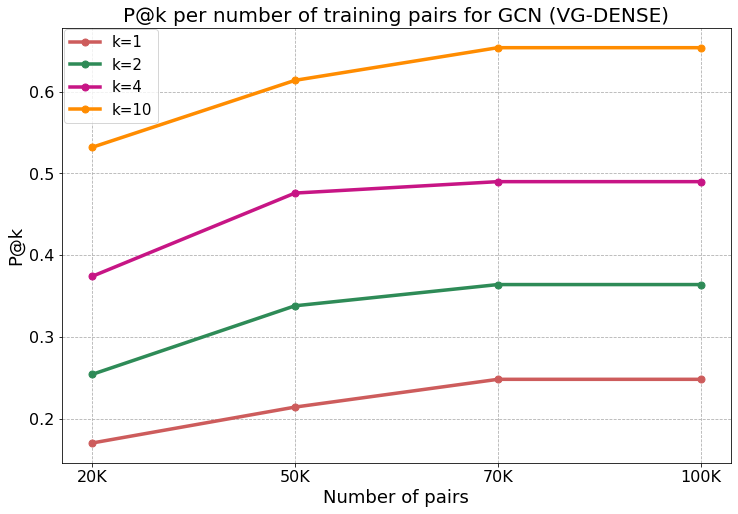

In [130]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
plt.title('P@k per number of training pairs for GCN (VG-DENSE)', fontsize=20)
plt.plot(gcn1, color='indianred', label='k=1', marker="o", linewidth=3.5,markersize=7)
plt.plot(gcn2, color='seagreen', label='k=2', marker="o", linewidth=3.5,markersize=7)
plt.plot(gcn4, color='mediumvioletred', label='k=4', marker="o", linewidth=3.5,markersize=7)
plt.plot(gcn10, color='darkorange', label='k=10', marker="o", linewidth=3.5,markersize=7)

plt.grid(True, linestyle='--')
plt.ylabel('P@k', fontsize=18)
plt.xlabel('Number of pairs', fontsize=18)
#locs, labels = plt.xticks()
labels = ['20K', '50K', '70K', '100K']
plt.yticks(fontsize=16)
plt.xticks(np.arange(4), labels, fontsize=16)
plt.legend(fontsize=15, loc='upper left', bbox_to_anchor=(-0.008,1.015)) # , bbox_to_anchor=(0.5,0)
plt.show()

#Kernels

 WL PM PA SM GH 

In [131]:
run_num = '5'

In [132]:
path = '/content/drive/MyDrive/data/kernel_outs/outs' + run_num 
sims = []
sims.append(pkl.load(open(path + '/sim500_wl.pkl', 'rb')))
sims.append(pkl.load(open(path + '/sim500_pm.pkl', 'rb')))
sims.append(pkl.load(open(path + '/sim500_pa_attr.pkl', 'rb')))
sims.append(pkl.load(open(path + '/sim500_sm_attr.pkl', 'rb')))
sims.append(pkl.load(open(path + '/sim500_gh_attr.pkl', 'rb')))

sims_rank = []
sims_rank.append(pkl.load(open(path + '/sim500_wl_rank.pkl', 'rb')))
sims_rank.append(pkl.load(open(path + '/sim500_pm_rank.pkl', 'rb')))
sims_rank.append(pkl.load(open(path + '/sim500_pa_attr_rank.pkl', 'rb')))
sims_rank.append(pkl.load(open(path + '/sim500_sm_attr_rank.pkl', 'rb')))
sims_rank.append(pkl.load(open(path + '/sim500_gh_attr_rank.pkl', 'rb')))

In [133]:
comp = []
for i in sims_rank:
  c = []
  for j in i:
    mj = max(j)
    new_j = j/mj
    c.append(new_j)

  comp.append(c)

In [134]:
emb_10_list = []
for i in range(len(comp)):
  emb_10 = find_all_similar(np.array(comp[i]))
  for idx in range(500):
    emb_10[idx] = [new_idxs[i][0] for i in emb_10[idx] ]
  emb_10 = [list(reversed(i)) for i in emb_10]
  emb_10_list.append(emb_10)

In [135]:
len(emb_10_list[0])

500

In [136]:
all_preds = []
for j in range(len(emb_10_list)):
  preds = []
  for i in range(500):
    idx = new_idxs[i][0]
    preds.append(get_rank_untargeted_class(idx, emb_10_list[j][i], class_dict)[:10])
  all_preds.append(preds)

In [137]:
hps, rbos, all_hps_list, all_rbos = score_stats([preds_gd[idx[0]][:10] for idx in new_idxs], all_preds)
hps_results['PM']=all_hps_list
rbo_results['PM']=all_rbos

---- k = 1 ----
(500, 1) (500, 1)
Hit Percentage: 0.074
Mean RBO: 0.074
(500, 1) (500, 1)
Hit Percentage: 0.132
Mean RBO: 0.132
(500, 1) (500, 1)
Hit Percentage: 0.07
Mean RBO: 0.07
(500, 1) (500, 1)
Hit Percentage: 0.068
Mean RBO: 0.068
(500, 1) (500, 1)
Hit Percentage: 0.016
Mean RBO: 0.016
---- k = 2 ----
(500, 2) (500, 2)
Hit Percentage: 0.103
Mean RBO: 0.0885
(500, 2) (500, 2)
Hit Percentage: 0.134
Mean RBO: 0.133
(500, 2) (500, 2)
Hit Percentage: 0.08
Mean RBO: 0.075
(500, 2) (500, 2)
Hit Percentage: 0.098
Mean RBO: 0.083
(500, 2) (500, 2)
Hit Percentage: 0.013
Mean RBO: 0.0145
---- k = 4 ----
(500, 4) (500, 4)
Hit Percentage: 0.1555
Mean RBO: 0.11745833333333332
(500, 4) (500, 4)
Hit Percentage: 0.1735
Mean RBO: 0.15154166666666666
(500, 4) (500, 4)
Hit Percentage: 0.1145
Mean RBO: 0.09145833333333331
(500, 4) (500, 4)
Hit Percentage: 0.1365
Mean RBO: 0.10595833333333332
(500, 4) (500, 4)
Hit Percentage: 0.013
Mean RBO: 0.01333333333333333
---- k = 10 ----
(500, 10) (500, 10)
Hi

In [138]:
ndcg_list = []
for k in [1,2,4,10]:
  print()
  print('--------{}--------'.format(k))
  for i in range(5):
    #[preds_gd[idx[0]][:10] for idx in new_idxs], all_preds
    n = compute_ndcg([preds_gd[idx[0]][:10] for idx in new_idxs], all_preds[i], k=k)
    print(n)
    if i==1:
      ndcg_list.append([k,n])
ndcg_results['PM'] = ndcg_list
ndcg_results


--------1--------
0.6212000000000001
0.6514000000000001
0.5903999999999999
0.6013
0.5511999999999999

--------2--------
0.6356370611408197
0.6572064815403458
0.6073267030025665
0.6135769570039483
0.5742488611151811

--------4--------
0.6607306057415067
0.6775337096319284
0.6435060463250104
0.6464988839491181
0.6223553165411646

--------10--------
0.8538619320425125
0.8616091914421086
0.8449970936706017
0.8469383762439253
0.8345578929708876


{'GCN-20K': [[1, 0.6922],
  [2, 0.69317385775411],
  [4, 0.7135878223743533],
  [10, 0.8760762972840218]],
 'GCN-50K': [[1, 0.7234],
  [2, 0.7208003631853095],
  [4, 0.7337548070396935],
  [10, 0.885453082773869]],
 'GCN-70K': [[1, 0.7417],
  [2, 0.7341939622964897],
  [4, 0.7470121483676987],
  [10, 0.8913339782876228]],
 'GCN-100K': [[1, 0.7417],
  [2, 0.7341939622964897],
  [4, 0.7470121483676987],
  [10, 0.8913339782876228]],
 'GIN-20K': [[1, 0.6371],
  [2, 0.6428139248116493],
  [4, 0.6740857718781601],
  [10, 0.8584360314198508]],
 'GIN-50K': [[1, 0.6957000000000001],
  [2, 0.6908141672731127],
  [4, 0.7080530437626762],
  [10, 0.87491854450826]],
 'GIN-70K': [[1, 0.6595],
  [2, 0.6691290297221119],
  [4, 0.6954221866456596],
  [10, 0.867841631977717]],
 'GIN-100K': [[1, 0.7202000000000001],
  [2, 0.7191975256727665],
  [4, 0.7363168298645818],
  [10, 0.8856219251695673]],
 'GAT-20K': [[1, 0.6945],
  [2, 0.6964249116765122],
  [4, 0.7150811974531629],
  [10, 0.876939124392341]],


In [139]:
ndcg_list_2 = []
for k in [1,2,4,10]:
  print()
  print('--------{}--------'.format(k))
  for i in range(5):
    n = compute_ndcg_2([preds_gd[idx[0]][:10] for idx in new_idxs], all_preds[i], k=k)
    print(n)
    if i==1:
      ndcg_list_2.append([k,n])
ndcg_results_2['PM'] = ndcg_list_2


--------1--------
0.13219999999999998
0.19100000000000003
0.13760000000000003
0.1308
0.11120000000000002

--------2--------
0.19303564890547897
0.2477135745154788
0.19805709105333608
0.19173379353381234
0.17350781833047904

--------4--------
0.28277355080504457
0.3313710562356315
0.28723658701805765
0.2816164673424115
0.26541729886554927

--------10--------
0.4738778659547851
0.5095266116126078
0.47715173035193204
0.4730290862962655
0.4611461710769911


In [140]:
prec_list = []
for k in [1,2,4,10]:
  print()
  print('--------{}--------'.format(k))
  for i in range(5):
    pr = np.mean([precision_k(b,c, k=k) for b,c in zip([preds_gd[idx[0]][:10] for idx in new_idxs], all_preds[i])])
    print(pr)
    if i==1:
      prec_list.append([k, pr])
precision_results['PM']=prec_list


--------1--------
0.074
0.132
0.07
0.068
0.016

--------2--------
0.114
0.186
0.094
0.104
0.018

--------4--------
0.162
0.258
0.132
0.13
0.02

--------10--------
0.268
0.352
0.206
0.206
0.028


In [141]:
for k1, i1, i2, i3, i4 in zip(precision_results.keys(), hps_results.values(), ndcg_results.values(),  precision_results.values(), ndcg_results_2.values()):
  print('\small',k1, "& \small {0:0.3f} &".format(i1[0][1]), " \small {0:0.3f} &".format(i1[1][1]),  " \small {0:0.3f} &".format(i1[2][1]),  " \small {0:0.3f} &".format(i1[3][1]), " \small {0:0.3f} &".format(i2[0][1]), " \small {0:0.3f} &".format(i2[1][1]),  " \small {0:0.3f} &".format(i2[2][1]),  " \small {0:0.3f} &".format(i2[3][1]),
        " \small {0:0.3f} &".format(i3[0][1]), " \small {0:0.3f} &".format(i3[1][1]),  " \small {0:0.3f} &".format(i3[2][1]),  " \small {0:0.3f} &".format(i3[3][1]), " \small {0:0.3f} &".format(i4[0][1]), " \small {0:0.3f} &".format(i4[1][1]),  " \small {0:0.3f} &".format(i4[2][1]),  " \small {0:0.3f} \\\\".format(i4[3][1]))    

\small GCN-20K & \small 0.170 &  \small 0.219 &  \small 0.280 &  \small 0.361 &  \small 0.692 &  \small 0.693 &  \small 0.714 &  \small 0.876 &  \small 0.170 &  \small 0.254 &  \small 0.374 &  \small 0.532 &  \small 0.213 &  \small 0.268 &  \small 0.350 &  \small 0.523 \\
\small GCN-50K & \small 0.214 &  \small 0.267 &  \small 0.338 &  \small 0.426 &  \small 0.723 &  \small 0.721 &  \small 0.734 &  \small 0.885 &  \small 0.214 &  \small 0.338 &  \small 0.476 &  \small 0.614 &  \small 0.249 &  \small 0.301 &  \small 0.379 &  \small 0.545 \\
\small GCN-70K & \small 0.248 &  \small 0.295 &  \small 0.372 &  \small 0.457 &  \small 0.742 &  \small 0.734 &  \small 0.747 &  \small 0.891 &  \small 0.248 &  \small 0.364 &  \small 0.490 &  \small 0.654 &  \small 0.280 &  \small 0.330 &  \small 0.405 &  \small 0.563 \\
\small GCN-100K & \small 0.248 &  \small 0.295 &  \small 0.372 &  \small 0.457 &  \small 0.742 &  \small 0.734 &  \small 0.747 &  \small 0.891 &  \small 0.248 &  \small 0.364 &  \sm

#GQA

In [142]:
import pickle as pkl
new_idxs = pkl.load(open(pth+'scene500_gqa_idx_train_2.pkl', 'rb'))
image_ids_vg_dense = pkl.load(open(pth+'images_ids_gqa.pkl', 'rb'))
vg_dense_classification = pkl.load(open(pth+'gqa.pkl', 'rb'))

In [143]:
syn_n = pkl.load(open(pth+'syn_n_graphs_train_2.pkl', 'rb'))

In [144]:
geds = pkl.load(open(pth+'geds_bipartite_costs_gqa2.pkl', 'rb'))

In [145]:
vg_dense_classification

vg_id           label  label_prob
0    2405936     coffee_shop    0.270096
1    2360207          grotto    0.497859
2    2378452        bathroom    0.395007
3    2400822   watering_hole    0.343175
4    2401440           ocean    0.211711
..       ...             ...         ...
494  2401290     childs_room    0.137974
495  2407581           beach    0.182982
496  2347549  science_museum    0.145129
497  2398740        crevasse    0.518633
498  2385632     childs_room    0.254702

[499 rows x 3 columns]

In [146]:
vg_dense_classification.loc[170.5] = 2344889, 'clean_room', 0.111111

#sort index
vg_dense_classification= vg_dense_classification.sort_index().reset_index(drop=True)

In [147]:
len(vg_dense_classification.label.unique())

161

In [148]:
[int(i) for i in image_ids_vg_dense] == list(vg_dense_classification['vg_id'])

True

In [149]:
gd_rank = find_all(geds, [i[0] for i in new_idxs])

In [150]:
gd = []
for idx in new_idxs:
  gd.append(gd_rank[idx[0]])

In [151]:
class_dict =  dict()
for i in range(len(new_idxs)):
  class_dict[new_idxs[i][0]] = vg_dense_classification.iloc[[i]]['label'].item()

In [152]:
preds_gd = {}
for i in range(500):
  idx = new_idxs[i][0]
  preds_gd[idx] = get_rank_untargeted_class(idx, gd[i], class_dict)

In [153]:
confident_rows = vg_dense_classification.loc[(vg_dense_classification['label_prob'] >= 0.5)]
confident_ids = list(confident_rows['vg_id'])

In [154]:
confident_ids_to_idx = [new_idxs[image_ids_vg_dense.index(str(i))][0] for i in confident_ids]

In [155]:
len(confident_ids_to_idx)

77

In [156]:
hps_results = {}
rbo_results = {}
ndcg_results = {}
precision_results = {}
ndcg_results_2 = {}

#GCN 20K

In [157]:
import numpy as np
embeddings_res = np.array(pkl.load(open(pth+'emb_gcn_gqa2_20k.pkl', 'rb')))

In [158]:
from tqdm import tqdm
from scipy import spatial

comp = []
for value in tqdm(range(embeddings_res.shape[0])):
  emb_comp = []
  for i in range(embeddings_res.shape[0]):
    emb_comp.append(1 - spatial.distance.cosine(embeddings_res[value], embeddings_res[i]))

  comp.append([i/max(emb_comp) for i in emb_comp])

emb_10 = find_all_similar(np.array(comp))
for idx in range(500):
  emb_10[idx] = [new_idxs[i][0] for i in emb_10[idx] ]

emb_10 = [list(reversed(i)) for i in emb_10]

100%|██████████| 500/500 [00:28<00:00, 17.45it/s]


In [159]:
preds = {}
for i in range(500):
  idx = new_idxs[i][0]
  preds[idx] = get_rank_untargeted_class(idx, emb_10[i], class_dict)

In [160]:
amount=500

In [161]:
hps, rbos, all_hps_list, all_rbos = score_stats([preds_gd[idx[0]][:10] for idx in new_idxs], [[preds[idx[0]][:10] for idx in new_idxs]])
hps_results['GCN-20K']=all_hps_list
rbo_results['GCN-20K']=all_rbos

---- k = 1 ----
(500, 1) (500, 1)
Hit Percentage: 0.152
Mean RBO: 0.152
---- k = 2 ----
(500, 2) (500, 2)
Hit Percentage: 0.225
Mean RBO: 0.1885
---- k = 4 ----
(500, 4) (500, 4)
Hit Percentage: 0.267
Mean RBO: 0.22116666666666665
---- k = 10 ----
(500, 10) (500, 10)
Hit Percentage: 0.365
Mean RBO: 0.2878454761904762


In [162]:
ndcg_list = []
for k in [1,2,4,10]:
  print()
  print('--------{}--------'.format(k))
  for i in range(len([emb_10])):
    n = compute_ndcg([preds_gd[idx[0]][:10] for idx in new_idxs], [preds[idx[0]][:10] for idx in new_idxs], k=k)
    print(n)
    ndcg_list.append([k,n])
ndcg_results['GCN-20K'] = ndcg_list


--------1--------
0.6691

--------2--------
0.6876198412844279

--------4--------
0.7049684529853926

--------10--------
0.8721760587732037


In [163]:
ndcg_list_2 = []
for k in [1,2,4,10]:
  print()
  print('--------{}--------'.format(k))
  for i in range(len([emb_10])):
    n = compute_ndcg_2([preds_gd[idx[0]][:10] for idx in new_idxs], [preds[idx[0]][:10] for idx in new_idxs], k=k)
    print(n)
    ndcg_list_2.append([k,n])
ndcg_results_2['GCN-20K'] = ndcg_list_2


--------1--------
0.19460000000000002

--------2--------
0.25106120261405024

--------4--------
0.33434641371097357

--------10--------
0.5117091878773726


In [164]:
prec_list = []
for k in [1,2,4,10]:
  print()
  print('--------{}--------'.format(k))
  for i in range(len([emb_10])):
    pr = np.mean([precision_k(b,c, k=k) for b,c in zip([preds_gd[idx[0]][:10] for idx in new_idxs], [preds[idx[0]][:10] for idx in new_idxs])])
    print(pr)
    prec_list.append([k, pr])
precision_results['GCN-20K']=prec_list


--------1--------
0.152

--------2--------
0.25

--------4--------
0.35

--------10--------
0.52


#GCN 50K

In [165]:
import numpy as np
embeddings_res = np.array(pkl.load(open(pth+'emb_gcn_gqa2_50k.pkl', 'rb')))

In [166]:
from tqdm import tqdm
from scipy import spatial

comp = []
for value in tqdm(range(embeddings_res.shape[0])):
  emb_comp = []
  for i in range(embeddings_res.shape[0]):
    emb_comp.append(1 - spatial.distance.cosine(embeddings_res[value], embeddings_res[i]))

  comp.append([i/max(emb_comp) for i in emb_comp])

emb_10 = find_all_similar(np.array(comp))
for idx in range(500):
  emb_10[idx] = [new_idxs[i][0] for i in emb_10[idx] ]

emb_10 = [list(reversed(i)) for i in emb_10]

100%|██████████| 500/500 [00:28<00:00, 17.35it/s]


In [167]:
preds = {}
for i in range(500):
  idx = new_idxs[i][0]
  preds[idx] = get_rank_untargeted_class(idx, emb_10[i], class_dict)

In [168]:
amount=500

In [169]:
hps, rbos, all_hps_list, all_rbos = score_stats([preds_gd[idx[0]][:10] for idx in new_idxs], [[preds[idx[0]][:10] for idx in new_idxs]])
hps_results['GCN-50K']=all_hps_list
rbo_results['GCN-50K']=all_rbos

---- k = 1 ----
(500, 1) (500, 1)
Hit Percentage: 0.188
Mean RBO: 0.188
---- k = 2 ----
(500, 2) (500, 2)
Hit Percentage: 0.258
Mean RBO: 0.223
---- k = 4 ----
(500, 4) (500, 4)
Hit Percentage: 0.3205
Mean RBO: 0.26529166666666665
---- k = 10 ----
(500, 10) (500, 10)
Hit Percentage: 0.4066
Mean RBO: 0.3312386507936508


In [170]:
ndcg_list = []
for k in [1,2,4,10]:
  print()
  print('--------{}--------'.format(k))
  for i in range(len([emb_10])):
    n = compute_ndcg([preds_gd[idx[0]][:10] for idx in new_idxs], [preds[idx[0]][:10] for idx in new_idxs], k=k)
    print(n)
    ndcg_list.append([k,n])
ndcg_results['GCN-50K'] = ndcg_list


--------1--------
0.7217

--------2--------
0.7195237990407468

--------4--------
0.7279639314071898

--------10--------
0.8837939918725795


In [171]:
ndcg_list_2 = []
for k in [1,2,4,10]:
  print()
  print('--------{}--------'.format(k))
  for i in range(len([emb_10])):
    n = compute_ndcg_2([preds_gd[idx[0]][:10] for idx in new_idxs], [preds[idx[0]][:10] for idx in new_idxs], k=k)
    print(n)
    ndcg_list_2.append([k,n])
ndcg_results_2['GCN-50K'] = ndcg_list_2


--------1--------
0.22319999999999998

--------2--------
0.27765624806381195

--------4--------
0.357983975876191

--------10--------
0.5290485437585585


In [172]:
prec_list
for k in [1,2,4,10]:
  print()
  print('--------{}--------'.format(k))
  for i in range(len([emb_10])):
    pr = np.mean([precision_k(b,c, k=k) for b,c in zip([preds_gd[idx[0]][:10] for idx in new_idxs], [preds[idx[0]][:10] for idx in new_idxs])])
    print(pr)
    prec_list.append([k, pr])
precision_results['GCN-50K']=prec_list


--------1--------
0.188

--------2--------
0.306

--------4--------
0.436

--------10--------
0.612


#GCN 70K

In [173]:
import numpy as np
embeddings_res = np.array(pkl.load(open(pth+'emb_gcn_gqa2_70k.pkl', 'rb')))

In [174]:
from tqdm import tqdm
from scipy import spatial

comp = []
for value in tqdm(range(embeddings_res.shape[0])):
  emb_comp = []
  for i in range(embeddings_res.shape[0]):
    emb_comp.append(1 - spatial.distance.cosine(embeddings_res[value], embeddings_res[i]))

  comp.append([i/max(emb_comp) for i in emb_comp])

emb_10 = find_all_similar(np.array(comp))
for idx in range(500):
  emb_10[idx] = [new_idxs[i][0] for i in emb_10[idx] ]

emb_10 = [list(reversed(i)) for i in emb_10]

100%|██████████| 500/500 [00:32<00:00, 15.26it/s]


In [175]:
preds = {}
for i in range(500):
  idx = new_idxs[i][0]
  preds[idx] = get_rank_untargeted_class(idx, emb_10[i], class_dict)

In [176]:
amount=500

In [177]:
hps, rbos, all_hps_list, all_rbos = score_stats([preds_gd[idx[0]][:10] for idx in new_idxs], [[preds[idx[0]][:10] for idx in new_idxs]])
hps_results['GCN-70K']=all_hps_list
rbo_results['GCN-70K']=all_rbos

---- k = 1 ----
(500, 1) (500, 1)
Hit Percentage: 0.188
Mean RBO: 0.188
---- k = 2 ----
(500, 2) (500, 2)
Hit Percentage: 0.286
Mean RBO: 0.237
---- k = 4 ----
(500, 4) (500, 4)
Hit Percentage: 0.341
Mean RBO: 0.28508333333333324
---- k = 10 ----
(500, 10) (500, 10)
Hit Percentage: 0.42979999999999996
Mean RBO: 0.35542579365079363


In [178]:
ndcg_list = []
for k in [1,2,4,10]:
  print()
  print('--------{}--------'.format(k))
  for i in range(len([emb_10])):
    n = compute_ndcg([preds_gd[idx[0]][:10] for idx in new_idxs], [preds[idx[0]][:10] for idx in new_idxs], k=k)
    print(n)
    ndcg_list.append([k,n])
ndcg_results['GCN-70K'] = ndcg_list


--------1--------
0.7249

--------2--------
0.7297652645649548

--------4--------
0.7403696724487302

--------10--------
0.8881516007548524


In [179]:
ndcg_list_2 = []
for k in [1,2,4,10]:
  print()
  print('--------{}--------'.format(k))
  for i in range(len([emb_10])):
    n = compute_ndcg_2([preds_gd[idx[0]][:10] for idx in new_idxs], [preds[idx[0]][:10] for idx in new_idxs], k=k)
    print(n)
    ndcg_list_2.append([k,n])
ndcg_results_2['GCN-70K'] = ndcg_list_2


--------1--------
0.22119999999999998

--------2--------
0.2757964546757168

--------4--------
0.356330999501001

--------10--------
0.5278360013892448


In [180]:
prec_list = []
for k in [1,2,4,10]:
  print()
  print('--------{}--------'.format(k))
  for i in range(len([emb_10])):
    pr = np.mean([precision_k(b,c, k=k) for b,c in zip([preds_gd[idx[0]][:10] for idx in new_idxs], [preds[idx[0]][:10] for idx in new_idxs])])
    print(pr)
    prec_list.append([k, pr])
precision_results['GCN-70K']=prec_list


--------1--------
0.188

--------2--------
0.332

--------4--------
0.478

--------10--------
0.656


In [181]:
set([preds[key][0] for key in preds]).intersection(set(confident_ids_to_idx))

{2923,
 3503,
 3872,
 5362,
 6906,
 7688,
 8027,
 8515,
 8636,
 8676,
 12909,
 17055,
 20161,
 23108,
 24541,
 25691,
 26498,
 27464,
 29751,
 33523,
 35499,
 35740,
 44659,
 47663,
 48891,
 50390,
 50994,
 52978,
 53946,
 55014,
 55054,
 63121,
 65816,
 66190,
 69105,
 71688,
 73275,
 73818,
 74898}

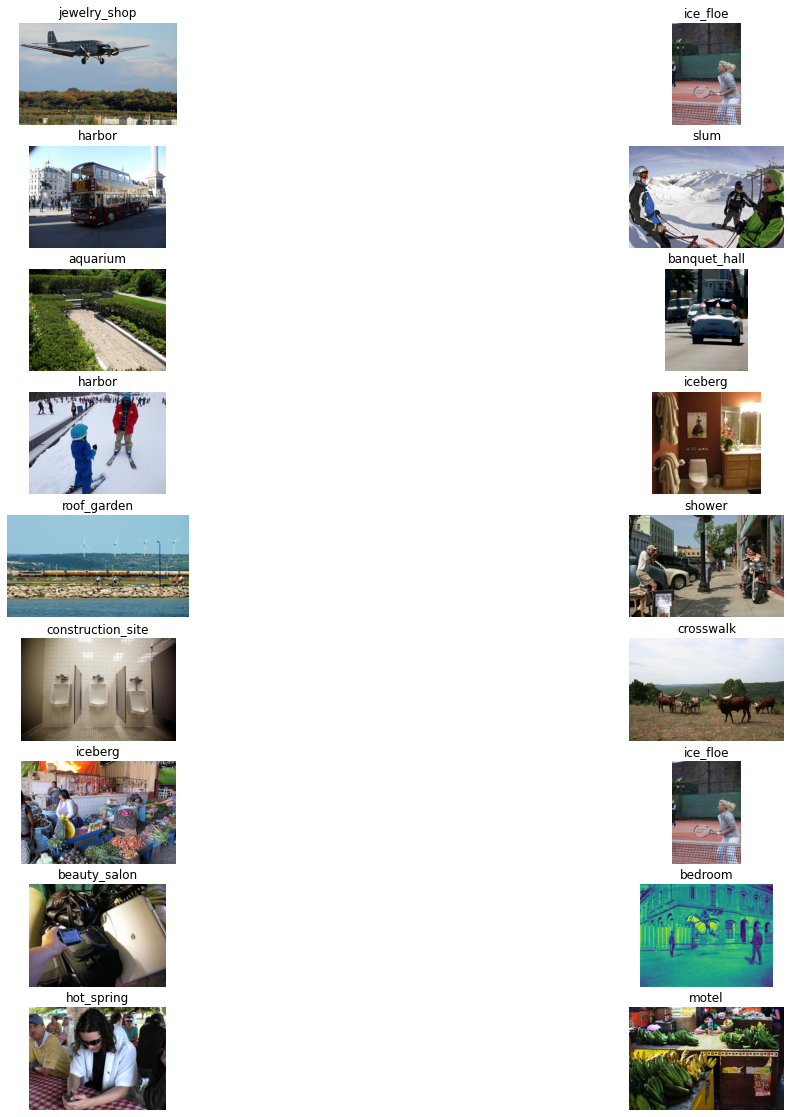

In [182]:
import matplotlib.pyplot as plt                    #id=8,13,17,26,28,29,33,36,37

f, axarr = plt.subplots(9,2,figsize=(20,20))
for i in range(len([8,13,17,26,28,29,33,36,37])):
    ax = i
    ll = [8,13,17,26,28,29,33,36,37]
    id = new_idxs[ll[i]][0]
    axarr[ax][0].imshow(print_image(id))
    axarr[ax][1].imshow(print_image(preds[id][0]))
    axarr[ax][0].title.set_text(class_dict[id])
    axarr[ax][1].title.set_text(class_dict[preds[id][0]])
    axarr[ax][0].axis('off')
    axarr[ax][1].axis('off')

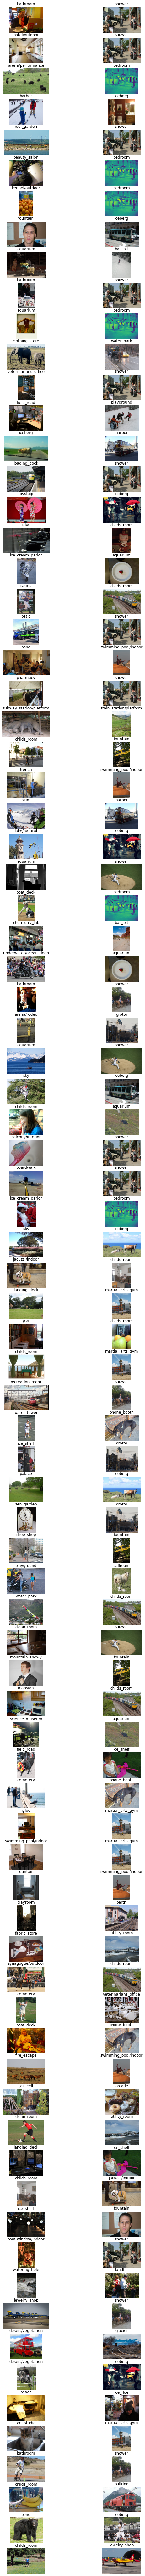

In [183]:
import matplotlib.pyplot as plt                                      #

to_print = []
for key in preds:
  # print(preds[key][0])
  if preds[key][0] in confident_ids_to_idx:
    to_print.append(key)

f, axarr = plt.subplots(len(to_print),2,figsize=(10,150))
for i in range(len(to_print)):
    ax = i
    # print(i)
    id = to_print[i]
    axarr[ax][0].imshow(print_image(id))
    axarr[ax][1].imshow(print_image(preds[id][0]))
    axarr[ax][0].title.set_text(class_dict[id])
    axarr[ax][1].title.set_text(class_dict[preds[id][0]])
    axarr[ax][0].axis('off')
    axarr[ax][1].axis('off')

#GCN 100K

In [184]:
import numpy as np
embeddings_res = np.array(pkl.load(open(pth+'emb_gcn_gqa2_100k.pkl', 'rb')))

In [185]:
from tqdm import tqdm
from scipy import spatial

comp = []
for value in tqdm(range(embeddings_res.shape[0])):
  emb_comp = []
  for i in range(embeddings_res.shape[0]):
    emb_comp.append(1 - spatial.distance.cosine(embeddings_res[value], embeddings_res[i]))

  comp.append([i/max(emb_comp) for i in emb_comp])

emb_10 = find_all_similar(np.array(comp))
for idx in range(500):
  emb_10[idx] = [new_idxs[i][0] for i in emb_10[idx] ]

emb_10 = [list(reversed(i)) for i in emb_10]

100%|██████████| 500/500 [00:28<00:00, 17.30it/s]


In [186]:
preds = {}
for i in range(500):
  idx = new_idxs[i][0]
  preds[idx] = get_rank_untargeted_class(idx, emb_10[i], class_dict)

In [187]:
amount=500

In [188]:
hps, rbos, all_hps_list, all_rbos = score_stats([preds_gd[idx[0]][:10] for idx in new_idxs], [[preds[idx[0]][:10] for idx in new_idxs]])
hps_results['GCN-100K']=all_hps_list
rbo_results['GCN-100K']=all_rbos

---- k = 1 ----
(500, 1) (500, 1)
Hit Percentage: 0.212
Mean RBO: 0.212
---- k = 2 ----
(500, 2) (500, 2)
Hit Percentage: 0.297
Mean RBO: 0.2545
---- k = 4 ----
(500, 4) (500, 4)
Hit Percentage: 0.348
Mean RBO: 0.2955833333333333
---- k = 10 ----
(500, 10) (500, 10)
Hit Percentage: 0.43939999999999996
Mean RBO: 0.3648207936507937


In [189]:
ndcg_list = []
for k in [1,2,4,10]:
  print()
  print('--------{}--------'.format(k))
  for i in range(len([emb_10])):
    n = compute_ndcg([preds_gd[idx[0]][:10] for idx in new_idxs], [preds[idx[0]][:10] for idx in new_idxs], k=k)
    print(n)
    ndcg_list.append([k,n])
ndcg_results['GCN-100K'] = ndcg_list


--------1--------
0.7283000000000001

--------2--------
0.7353678464275563

--------4--------
0.7437160751416496

--------10--------
0.8898420850669181


In [190]:
ndcg_list_2 = []
for k in [1,2,4,10]:
  print()
  print('--------{}--------'.format(k))
  for i in range(len([emb_10])):
    n = compute_ndcg_2([preds_gd[idx[0]][:10] for idx in new_idxs], [preds[idx[0]][:10] for idx in new_idxs], k=k)
    print(n)
    ndcg_list_2.append([k,n])
ndcg_results_2['GCN-100K'] = ndcg_list_2


--------1--------
0.2416

--------2--------
0.2947663472342882

--------4--------
0.37319135852793933

--------10--------
0.5402039335562446


In [191]:
prec_list = []

for k in [1,2,4,10]:
  print()
  print('--------{}--------'.format(k))
  for i in range(len([emb_10])):
    pr = np.mean([precision_k(b,c, k=k) for b,c in zip([preds_gd[idx[0]][:10] for idx in new_idxs], [preds[idx[0]][:10] for idx in new_idxs])])
    print(pr)
    prec_list.append([k, pr])
precision_results['GCN-100K']=prec_list


--------1--------
0.212

--------2--------
0.34

--------4--------
0.474

--------10--------
0.692


#GIN 20K

In [192]:
import numpy as np
embeddings_res = np.array(pkl.load(open(pth+'emb_gin_gqa2_20k.pkl', 'rb')))

In [193]:
from tqdm import tqdm
from scipy import spatial

comp = []
for value in tqdm(range(embeddings_res.shape[0])):
  emb_comp = []
  for i in range(embeddings_res.shape[0]):
    emb_comp.append(1 - spatial.distance.cosine(embeddings_res[value], embeddings_res[i]))

  comp.append([i/max(emb_comp) for i in emb_comp])

emb_10 = find_all_similar(np.array(comp))
for idx in range(500):
  emb_10[idx] = [new_idxs[i][0] for i in emb_10[idx] ]

emb_10 = [list(reversed(i)) for i in emb_10]

100%|██████████| 500/500 [00:28<00:00, 17.49it/s]


In [194]:
preds = {}
for i in range(500):
  idx = new_idxs[i][0]
  preds[idx] = get_rank_untargeted_class(idx, emb_10[i], class_dict)

In [195]:
amount=500

In [196]:
hps, rbos, all_hps_list, all_rbos = score_stats([preds_gd[idx[0]][:10] for idx in new_idxs], [[preds[idx[0]][:10] for idx in new_idxs]])
hps_results['GIN-20K']=all_hps_list
rbo_results['GIN-20K']=all_rbos

---- k = 1 ----
(500, 1) (500, 1)
Hit Percentage: 0.142
Mean RBO: 0.142
---- k = 2 ----
(500, 2) (500, 2)
Hit Percentage: 0.173
Mean RBO: 0.1575
---- k = 4 ----
(500, 4) (500, 4)
Hit Percentage: 0.203
Mean RBO: 0.17633333333333331
---- k = 10 ----
(500, 10) (500, 10)
Hit Percentage: 0.2866
Mean RBO: 0.22477325396825398


In [197]:
ndcg_list = []
for k in [1,2,4,10]:
  print()
  print('--------{}--------'.format(k))
  for i in range(len([emb_10])):
    n = compute_ndcg([preds_gd[idx[0]][:10] for idx in new_idxs], [preds[idx[0]][:10] for idx in new_idxs], k=k)
    print(n)
    ndcg_list.append([k,n])
ndcg_results['GIN-20K'] = ndcg_list


--------1--------
0.669

--------2--------
0.6651859473633798

--------4--------
0.6883481259358096

--------10--------
0.8661058081170658


In [198]:
ndcg_list_2 = []
for k in [1,2,4,10]:
  print()
  print('--------{}--------'.format(k))
  for i in range(len([emb_10])):
    n = compute_ndcg_2([preds_gd[idx[0]][:10] for idx in new_idxs], [preds[idx[0]][:10] for idx in new_idxs], k=k)
    print(n)
    ndcg_list_2.append([k,n])
ndcg_results_2['GIN-20K'] = ndcg_list_2


--------1--------
0.19440000000000004

--------2--------
0.2508752232752407

--------4--------
0.3341811160734545

--------10--------
0.5115879336404412


In [199]:
prec_list = []

for k in [1,2,4,10]:
  print()
  print('--------{}--------'.format(k))
  for i in range(len([emb_10])):
    pr = np.mean([precision_k(b,c, k=k) for b,c in zip([preds_gd[idx[0]][:10] for idx in new_idxs], [preds[idx[0]][:10] for idx in new_idxs])])
    print(pr)
    prec_list.append([k, pr])
precision_results['GIN-20K']=prec_list


--------1--------
0.142

--------2--------
0.216

--------4--------
0.302

--------10--------
0.45


#GIN 50K

In [200]:
import pickle as pkl

In [201]:
import numpy as np
embeddings_res = np.array(pkl.load(open(pth+'emb_gin_gqa2_50k.pkl', 'rb')))

In [202]:
from tqdm import tqdm
from scipy import spatial

comp = []
for value in tqdm(range(embeddings_res.shape[0])):
  emb_comp = []
  for i in range(embeddings_res.shape[0]):
    emb_comp.append(1 - spatial.distance.cosine(embeddings_res[value], embeddings_res[i]))

  comp.append([i/max(emb_comp) for i in emb_comp])

emb_10 = find_all_similar(np.array(comp))
for idx in range(500):
  emb_10[idx] = [new_idxs[i][0] for i in emb_10[idx] ]

emb_10 = [list(reversed(i)) for i in emb_10]

100%|██████████| 500/500 [00:28<00:00, 17.46it/s]


In [203]:
preds = {}
for i in range(500):
  idx = new_idxs[i][0]
  preds[idx] = get_rank_untargeted_class(idx, emb_10[i], class_dict)

In [204]:
amount=500

In [205]:
hps, rbos, all_hps_list, all_rbos = score_stats([preds_gd[idx[0]][:10] for idx in new_idxs], [[preds[idx[0]][:10] for idx in new_idxs]])
hps_results['GIN-50K']=all_hps_list
rbo_results['GIN-50K']=all_rbos

---- k = 1 ----
(500, 1) (500, 1)
Hit Percentage: 0.156
Mean RBO: 0.156
---- k = 2 ----
(500, 2) (500, 2)
Hit Percentage: 0.207
Mean RBO: 0.1815
---- k = 4 ----
(500, 4) (500, 4)
Hit Percentage: 0.2735
Mean RBO: 0.22312499999999996
---- k = 10 ----
(500, 10) (500, 10)
Hit Percentage: 0.34779999999999994
Mean RBO: 0.28120357142857144


In [206]:
ndcg_list = []
for k in [1,2,4,10]:
  print()
  print('--------{}--------'.format(k))
  for i in range(len([emb_10])):
    n = compute_ndcg([preds_gd[idx[0]][:10] for idx in new_idxs], [preds[idx[0]][:10] for idx in new_idxs], k=k)
    print(n)
    ndcg_list.append([k,n])
ndcg_results['GIN-50K'] = ndcg_list


--------1--------
0.6782999999999999

--------2--------
0.6862710570167676

--------4--------
0.7054450173977794

--------10--------
0.8727363093695554


In [207]:
ndcg_list_2 = []
for k in [1,2,4,10]:
  print()
  print('--------{}--------'.format(k))
  for i in range(len([emb_10])):
    n = compute_ndcg_2([preds_gd[idx[0]][:10] for idx in new_idxs], [preds[idx[0]][:10] for idx in new_idxs], k=k)
    print(n)
    ndcg_list_2.append([k,n])
ndcg_results_2['GIN-50K'] = ndcg_list_2


--------1--------
0.1918

--------2--------
0.2484574918707169

--------4--------
0.3320322467857076

--------10--------
0.5100116285603334


In [208]:
prec_list = []

for k in [1,2,4,10]:
  print()
  print('--------{}--------'.format(k))
  for i in range(len([emb_10])):
    pr = np.mean([precision_k(b,c, k=k) for b,c in zip([preds_gd[idx[0]][:10] for idx in new_idxs], [preds[idx[0]][:10] for idx in new_idxs])])
    print(pr)
    prec_list.append([k, pr])
precision_results['GIN-50K']=prec_list


--------1--------
0.156

--------2--------
0.24

--------4--------
0.348

--------10--------
0.518


#GIN 70K

In [209]:
import pickle as pkl

In [210]:
import numpy as np
embeddings_res = np.array(pkl.load(open(pth+'emb_gin_gqa2_70k.pkl', 'rb')))

In [211]:
from tqdm import tqdm
from scipy import spatial

comp = []
for value in tqdm(range(embeddings_res.shape[0])):
  emb_comp = []
  for i in range(embeddings_res.shape[0]):
    emb_comp.append(1 - spatial.distance.cosine(embeddings_res[value], embeddings_res[i]))

  comp.append([i/max(emb_comp) for i in emb_comp])

emb_10 = find_all_similar(np.array(comp))
for idx in range(500):
  emb_10[idx] = [new_idxs[i][0] for i in emb_10[idx] ]

emb_10 = [list(reversed(i)) for i in emb_10]

100%|██████████| 500/500 [00:28<00:00, 17.30it/s]


In [212]:
preds = {}
for i in range(500):
  idx = new_idxs[i][0]
  preds[idx] = get_rank_untargeted_class(idx, emb_10[i], class_dict)

In [213]:
amount=500

In [214]:
hps, rbos, all_hps_list, all_rbos = score_stats([preds_gd[idx[0]][:10] for idx in new_idxs], [[preds[idx[0]][:10] for idx in new_idxs]])
hps_results['GIN-70K']=all_hps_list
rbo_results['GIN-70K']=all_rbos

---- k = 1 ----
(500, 1) (500, 1)
Hit Percentage: 0.156
Mean RBO: 0.156
---- k = 2 ----
(500, 2) (500, 2)
Hit Percentage: 0.244
Mean RBO: 0.2
---- k = 4 ----
(500, 4) (500, 4)
Hit Percentage: 0.2855
Mean RBO: 0.23620833333333333
---- k = 10 ----
(500, 10) (500, 10)
Hit Percentage: 0.361
Mean RBO: 0.2957886507936508


In [215]:
ndcg_list = []
for k in [1,2,4,10]:
  print()
  print('--------{}--------'.format(k))
  for i in range(len([emb_10])):
    n = compute_ndcg([preds_gd[idx[0]][:10] for idx in new_idxs], [preds[idx[0]][:10] for idx in new_idxs], k=k)
    print(n)
    ndcg_list.append([k,n])
ndcg_results['GIN-70K'] = ndcg_list


--------1--------
0.6966000000000001

--------2--------
0.6991996368146906

--------4--------
0.7206024687874087

--------10--------
0.8785650591432068


In [216]:
ndcg_list_2 = []
for k in [1,2,4,10]:
  print()
  print('--------{}--------'.format(k))
  for i in range(len([emb_10])):
    n = compute_ndcg_2([preds_gd[idx[0]][:10] for idx in new_idxs], [preds[idx[0]][:10] for idx in new_idxs], k=k)
    print(n)
    ndcg_list_2.append([k,n])
ndcg_results_2['GIN-70K'] = ndcg_list_2


--------1--------
0.19540000000000005

--------2--------
0.2518051199692883

--------4--------
0.3350076042610496

--------10--------
0.512194204825098


In [217]:
prec_list = []

for k in [1,2,4,10]:
  print()
  print('--------{}--------'.format(k))
  for i in range(len([emb_10])):
    pr = np.mean([precision_k(b,c, k=k) for b,c in zip([preds_gd[idx[0]][:10] for idx in new_idxs], [preds[idx[0]][:10] for idx in new_idxs])])
    print(pr)
    prec_list.append([k, pr])
precision_results['GIN-70K']=prec_list


--------1--------
0.156

--------2--------
0.274

--------4--------
0.392

--------10--------
0.584


#GIN 100K

In [218]:
import pickle as pkl

In [219]:
import numpy as np
embeddings_res = np.array(pkl.load(open(pth+'emb_gin_gqa2_100k.pkl', 'rb')))

In [220]:
from tqdm import tqdm
from scipy import spatial

comp = []
for value in tqdm(range(embeddings_res.shape[0])):
  emb_comp = []
  for i in range(embeddings_res.shape[0]):
    emb_comp.append(1 - spatial.distance.cosine(embeddings_res[value], embeddings_res[i]))

  comp.append([i/max(emb_comp) for i in emb_comp])

emb_10 = find_all_similar(np.array(comp))
for idx in range(500):
  emb_10[idx] = [new_idxs[i][0] for i in emb_10[idx] ]

emb_10 = [list(reversed(i)) for i in emb_10]

100%|██████████| 500/500 [00:32<00:00, 15.24it/s]


In [221]:
preds = {}
for i in range(500):
  idx = new_idxs[i][0]
  preds[idx] = get_rank_untargeted_class(idx, emb_10[i], class_dict)

In [222]:
amount=500

In [223]:
hps, rbos, all_hps_list, all_rbos = score_stats([preds_gd[idx[0]][:10] for idx in new_idxs], [[preds[idx[0]][:10] for idx in new_idxs]])
hps_results['GIN-100K']=all_hps_list
rbo_results['GIN-100K']=all_rbos

---- k = 1 ----
(500, 1) (500, 1)
Hit Percentage: 0.2
Mean RBO: 0.2
---- k = 2 ----
(500, 2) (500, 2)
Hit Percentage: 0.257
Mean RBO: 0.2285
---- k = 4 ----
(500, 4) (500, 4)
Hit Percentage: 0.312
Mean RBO: 0.26558333333333334
---- k = 10 ----
(500, 10) (500, 10)
Hit Percentage: 0.3954
Mean RBO: 0.3244477777777778


In [224]:
ndcg_list = []
for k in [1,2,4,10]:
  print()
  print('--------{}--------'.format(k))
  for i in range(len([emb_10])):
    n = compute_ndcg([preds_gd[idx[0]][:10] for idx in new_idxs], [preds[idx[0]][:10] for idx in new_idxs], k=k)
    print(n)
    ndcg_list.append([k,n])
ndcg_results['GIN-100K'] = ndcg_list


--------1--------
0.7203

--------2--------
0.7086865897853534

--------4--------
0.7239155591565003

--------10--------
0.8818834767557872


In [225]:
ndcg_list_2 = []
for k in [1,2,4,10]:
  print()
  print('--------{}--------'.format(k))
  for i in range(len([emb_10])):
    n = compute_ndcg_2([preds_gd[idx[0]][:10] for idx in new_idxs], [preds[idx[0]][:10] for idx in new_idxs], k=k)
    print(n)
    ndcg_list_2.append([k,n])
ndcg_results_2['GIN-100K'] = ndcg_list_2


--------1--------
0.23200000000000004

--------2--------
0.28583933897143105

--------4--------
0.3652570719270272

--------10--------
0.5343837301835388


In [226]:
prec_list = []

for k in [1,2,4,10]:
  print()
  print('--------{}--------'.format(k))
  for i in range(len([emb_10])):
    pr = np.mean([precision_k(b,c, k=k) for b,c in zip([preds_gd[idx[0]][:10] for idx in new_idxs], [preds[idx[0]][:10] for idx in new_idxs])])
    print(pr)
    prec_list.append([k, pr])
precision_results['GIN-100K']=prec_list


--------1--------
0.2

--------2--------
0.32

--------4--------
0.42

--------10--------
0.6


#GAT 20K

In [227]:
import pickle as pkl

In [228]:
import numpy as np
embeddings_res = np.array(pkl.load(open(pth+'emb_gat_gqa2_20k.pkl', 'rb')))

In [229]:
from tqdm import tqdm
from scipy import spatial

comp = []
for value in tqdm(range(embeddings_res.shape[0])):
  emb_comp = []
  for i in range(embeddings_res.shape[0]):
    emb_comp.append(1 - spatial.distance.cosine(embeddings_res[value], embeddings_res[i]))

  comp.append([i/max(emb_comp) for i in emb_comp])

emb_10 = find_all_similar(np.array(comp))
for idx in range(500):
  emb_10[idx] = [new_idxs[i][0] for i in emb_10[idx] ]

emb_10 = [list(reversed(i)) for i in emb_10]

100%|██████████| 500/500 [00:33<00:00, 14.92it/s]


In [230]:
preds = {}
for i in range(500):
  idx = new_idxs[i][0]
  preds[idx] = get_rank_untargeted_class(idx, emb_10[i], class_dict)

In [231]:
amount=500

In [232]:
hps, rbos, all_hps_list, all_rbos = score_stats([preds_gd[idx[0]][:10] for idx in new_idxs], [[preds[idx[0]][:10] for idx in new_idxs]])
hps_results['GAT-20K']=all_hps_list
rbo_results['GAT-20K']=all_rbos

---- k = 1 ----
(500, 1) (500, 1)
Hit Percentage: 0.116
Mean RBO: 0.116
---- k = 2 ----
(500, 2) (500, 2)
Hit Percentage: 0.172
Mean RBO: 0.144
---- k = 4 ----
(500, 4) (500, 4)
Hit Percentage: 0.219
Mean RBO: 0.1755833333333333
---- k = 10 ----
(500, 10) (500, 10)
Hit Percentage: 0.30260000000000004
Mean RBO: 0.2345472222222222


In [233]:
ndcg_list = []
for k in [1,2,4,10]:
  print()
  print('--------{}--------'.format(k))
  for i in range(len([emb_10])):
    n = compute_ndcg([preds_gd[idx[0]][:10] for idx in new_idxs], [preds[idx[0]][:10] for idx in new_idxs], k=k)
    print(n)
    ndcg_list.append([k,n])
ndcg_results['GAT-20K'] = ndcg_list


--------1--------
0.663

--------2--------
0.6713658762990813

--------4--------
0.6937238622179881

--------10--------
0.8674229107173742


In [234]:
ndcg_list_2 = []
for k in [1,2,4,10]:
  print()
  print('--------{}--------'.format(k))
  for i in range(len([emb_10])):
    n = compute_ndcg_2([preds_gd[idx[0]][:10] for idx in new_idxs], [preds[idx[0]][:10] for idx in new_idxs], k=k)
    print(n)
    ndcg_list_2.append([k,n])
ndcg_results_2['GAT-20K'] = ndcg_list_2


--------1--------
0.16660000000000003

--------2--------
0.22502409518071698

--------4--------
0.31120474445831314

--------10--------
0.49473359470698075


In [235]:
prec_list = []

for k in [1,2,4,10]:
  print()
  print('--------{}--------'.format(k))
  for i in range(len([emb_10])):
    pr = np.mean([precision_k(b,c, k=k) for b,c in zip([preds_gd[idx[0]][:10] for idx in new_idxs], [preds[idx[0]][:10] for idx in new_idxs])])
    print(pr)
    prec_list.append([k, pr])
precision_results['GAT-20K']=prec_list


--------1--------
0.116

--------2--------
0.186

--------4--------
0.28

--------10--------
0.472


#GAT 50K

In [236]:
import pickle as pkl

In [237]:
import numpy as np
embeddings_res = np.array(pkl.load(open(pth+'emb_gat_gqa2_50k.pkl', 'rb')))

In [238]:
from tqdm import tqdm
from scipy import spatial

comp = []
for value in tqdm(range(embeddings_res.shape[0])):
  emb_comp = []
  for i in range(embeddings_res.shape[0]):
    emb_comp.append(1 - spatial.distance.cosine(embeddings_res[value], embeddings_res[i]))

  comp.append([i/max(emb_comp) for i in emb_comp])

emb_10 = find_all_similar(np.array(comp))
for idx in range(500):
  emb_10[idx] = [new_idxs[i][0] for i in emb_10[idx] ]

emb_10 = [list(reversed(i)) for i in emb_10]

100%|██████████| 500/500 [00:33<00:00, 14.85it/s]


In [239]:
preds = {}
for i in range(500):
  idx = new_idxs[i][0]
  preds[idx] = get_rank_untargeted_class(idx, emb_10[i], class_dict)

In [240]:
amount=500

In [241]:
hps, rbos, all_hps_list, all_rbos = score_stats([preds_gd[idx[0]][:10] for idx in new_idxs], [[preds[idx[0]][:10] for idx in new_idxs]])
hps_results['GAT-50K']=all_hps_list
rbo_results['GAT-50K']=all_rbos

---- k = 1 ----
(500, 1) (500, 1)
Hit Percentage: 0.128
Mean RBO: 0.128
---- k = 2 ----
(500, 2) (500, 2)
Hit Percentage: 0.167
Mean RBO: 0.1475
---- k = 4 ----
(500, 4) (500, 4)
Hit Percentage: 0.221
Mean RBO: 0.17833333333333332
---- k = 10 ----
(500, 10) (500, 10)
Hit Percentage: 0.302
Mean RBO: 0.23466484126984125


In [242]:
ndcg_list = []
for k in [1,2,4,10]:
  print()
  print('--------{}--------'.format(k))
  for i in range(len([emb_10])):
    n = compute_ndcg([preds_gd[idx[0]][:10] for idx in new_idxs], [preds[idx[0]][:10] for idx in new_idxs], k=k)
    print(n)
    ndcg_list.append([k,n])
ndcg_results['GAT-50K'] = ndcg_list


--------1--------
0.6601

--------2--------
0.6713449718356812

--------4--------
0.6925336562709974

--------10--------
0.8669686300282722


In [243]:
ndcg_list_2 = []
for k in [1,2,4,10]:
  print()
  print('--------{}--------'.format(k))
  for i in range(len([emb_10])):
    n = compute_ndcg_2([preds_gd[idx[0]][:10] for idx in new_idxs], [preds[idx[0]][:10] for idx in new_idxs], k=k)
    print(n)
    ndcg_list_2.append([k,n])
ndcg_results_2['GAT-50K'] = ndcg_list_2


--------1--------
0.1784

--------2--------
0.23599687617047882

--------4--------
0.32095730507193426

--------10--------
0.5018875946859316


In [244]:
prec_list = []

for k in [1,2,4,10]:
  print()
  print('--------{}--------'.format(k))
  for i in range(len([emb_10])):
    pr = np.mean([precision_k(b,c, k=k) for b,c in zip([preds_gd[idx[0]][:10] for idx in new_idxs], [preds[idx[0]][:10] for idx in new_idxs])])
    print(pr)
    prec_list.append([k, pr])
precision_results['GAT-50K']=prec_list


--------1--------
0.128

--------2--------
0.204

--------4--------
0.308

--------10--------
0.466


#GAT 70K

In [245]:
import pickle as pkl

In [246]:
import numpy as np
embeddings_res = np.array(pkl.load(open(pth+'emb_gat_gqa2_70k.pkl', 'rb')))

In [247]:
from tqdm import tqdm
from scipy import spatial

comp = []
for value in tqdm(range(embeddings_res.shape[0])):
  emb_comp = []
  for i in range(embeddings_res.shape[0]):
    emb_comp.append(1 - spatial.distance.cosine(embeddings_res[value], embeddings_res[i]))

  comp.append([i/max(emb_comp) for i in emb_comp])

emb_10 = find_all_similar(np.array(comp))
for idx in range(500):
  emb_10[idx] = [new_idxs[i][0] for i in emb_10[idx] ]

emb_10 = [list(reversed(i)) for i in emb_10]

100%|██████████| 500/500 [00:33<00:00, 14.98it/s]


In [248]:
preds = {}
for i in range(500):
  idx = new_idxs[i][0]
  preds[idx] = get_rank_untargeted_class(idx, emb_10[i], class_dict)

In [249]:
amount=500

In [250]:
hps, rbos, all_hps_list, all_rbos = score_stats([preds_gd[idx[0]][:10] for idx in new_idxs], [[preds[idx[0]][:10] for idx in new_idxs]])
hps_results['GAT-70K']=all_hps_list
rbo_results['GAT-70K']=all_rbos

---- k = 1 ----
(500, 1) (500, 1)
Hit Percentage: 0.126
Mean RBO: 0.126
---- k = 2 ----
(500, 2) (500, 2)
Hit Percentage: 0.172
Mean RBO: 0.149
---- k = 4 ----
(500, 4) (500, 4)
Hit Percentage: 0.222
Mean RBO: 0.182
---- k = 10 ----
(500, 10) (500, 10)
Hit Percentage: 0.30260000000000004
Mean RBO: 0.2382531746031746


In [251]:
ndcg_list = []
for k in [1,2,4,10]:
  print()
  print('--------{}--------'.format(k))
  for i in range(len([emb_10])):
    n = compute_ndcg([preds_gd[idx[0]][:10] for idx in new_idxs], [preds[idx[0]][:10] for idx in new_idxs], k=k)
    print(n)
    ndcg_list.append([k,n])
ndcg_results['GAT-70K'] = ndcg_list


--------1--------
0.6635

--------2--------
0.6752931580645787

--------4--------
0.6933351000089503

--------10--------
0.8676857302738037


In [252]:
ndcg_list_2 = []
for k in [1,2,4,10]:
  print()
  print('--------{}--------'.format(k))
  for i in range(len([emb_10])):
    n = compute_ndcg_2([preds_gd[idx[0]][:10] for idx in new_idxs], [preds[idx[0]][:10] for idx in new_idxs], k=k)
    print(n)
    ndcg_list_2.append([k,n])
ndcg_results_2['GAT-70K'] = ndcg_list_2


--------1--------
0.17740000000000003

--------2--------
0.2350669794764312

--------4--------
0.3201308168843393

--------10--------
0.5012813235012747


In [253]:
prec_list = []

for k in [1,2,4,10]:
  print()
  print('--------{}--------'.format(k))
  for i in range(len([emb_10])):
    pr = np.mean([precision_k(b,c, k=k) for b,c in zip([preds_gd[idx[0]][:10] for idx in new_idxs], [preds[idx[0]][:10] for idx in new_idxs])])
    print(pr)
    prec_list.append([k, pr])
precision_results['GAT-70K']=prec_list


--------1--------
0.126

--------2--------
0.214

--------4--------
0.302

--------10--------
0.458


#GAT 100K

In [254]:
import pickle as pkl

In [255]:
import numpy as np
embeddings_res = np.array(pkl.load(open(pth+'emb_gat_gqa2_100k.pkl', 'rb')))

In [256]:
from tqdm import tqdm
from scipy import spatial

comp = []
for value in tqdm(range(embeddings_res.shape[0])):
  emb_comp = []
  for i in range(embeddings_res.shape[0]):
    emb_comp.append(1 - spatial.distance.cosine(embeddings_res[value], embeddings_res[i]))

  comp.append([i/max(emb_comp) for i in emb_comp])

emb_10 = find_all_similar(np.array(comp))
for idx in range(500):
  emb_10[idx] = [new_idxs[i][0] for i in emb_10[idx] ]

emb_10 = [list(reversed(i)) for i in emb_10]

100%|██████████| 500/500 [00:33<00:00, 14.95it/s]


In [257]:
preds = {}
for i in range(500):
  idx = new_idxs[i][0]
  preds[idx] = get_rank_untargeted_class(idx, emb_10[i], class_dict)

In [258]:
amount=500

In [259]:
hps, rbos, all_hps_list, all_rbos = score_stats([preds_gd[idx[0]][:10] for idx in new_idxs], [[preds[idx[0]][:10] for idx in new_idxs]])
hps_results['GAT-100K']=all_hps_list
rbo_results['GAT-100K']=all_rbos

---- k = 1 ----
(500, 1) (500, 1)
Hit Percentage: 0.134
Mean RBO: 0.134
---- k = 2 ----
(500, 2) (500, 2)
Hit Percentage: 0.17
Mean RBO: 0.152
---- k = 4 ----
(500, 4) (500, 4)
Hit Percentage: 0.2165
Mean RBO: 0.17829166666666665
---- k = 10 ----
(500, 10) (500, 10)
Hit Percentage: 0.29560000000000003
Mean RBO: 0.2306652380952381


In [260]:
ndcg_list = []
for k in [1,2,4,10]:
  print()
  print('--------{}--------'.format(k))
  for i in range(len([emb_10])):
    n = compute_ndcg([preds_gd[idx[0]][:10] for idx in new_idxs], [preds[idx[0]][:10] for idx in new_idxs], k=k)
    print(n)
    ndcg_list.append([k,n])
ndcg_results['GAT-100K'] = ndcg_list


--------1--------
0.6602

--------2--------
0.6777714701657561

--------4--------
0.6927253838395439

--------10--------
0.8675261431355868


In [261]:
ndcg_list_2 = []
for k in [1,2,4,10]:
  print()
  print('--------{}--------'.format(k))
  for i in range(len([emb_10])):
    n = compute_ndcg_2([preds_gd[idx[0]][:10] for idx in new_idxs], [preds[idx[0]][:10] for idx in new_idxs], k=k)
    print(n)
    ndcg_list_2.append([k,n])
ndcg_results_2['GAT-100K'] = ndcg_list_2


--------1--------
0.18640000000000004

--------2--------
0.24343604972285973

--------4--------
0.32756921057269445

--------10--------
0.5067377641631864


In [262]:
prec_list = []

for k in [1,2,4,10]:
  print()
  print('--------{}--------'.format(k))
  for i in range(len([emb_10])):
    pr = np.mean([precision_k(b,c, k=k) for b,c in zip([preds_gd[idx[0]][:10] for idx in new_idxs], [preds[idx[0]][:10] for idx in new_idxs])])
    print(pr)
    prec_list.append([k, pr])
precision_results['GAT-100K']=prec_list


--------1--------
0.134

--------2--------
0.216

--------4--------
0.326

--------10--------
0.496


In [263]:
gcn1, gcn2, gcn4, gcn10 = [], [], [], []
gat = []
gin = []
for k, vals in precision_results.items():
  print(k)
  if 'GCN-' in k:
    print('GCN')
    print(vals[0][1])
    gcn1.append(vals[0][1])
    gcn2.append(vals[1][1])
    gcn4.append(vals[2][1])
    gcn10.append(vals[3][1])
  if 'GAT-' in k:
    print('GAT')
    gat.append(vals[0][1])
  if 'GIN-' in k:
    print('GIN')
    gin.append(vals[0][1])

GCN-20K
GCN
0.152
GCN-50K
GCN
0.152
GCN-70K
GCN
0.188
GCN-100K
GCN
0.212
GIN-20K
GIN
GIN-50K
GIN
GIN-70K
GIN
GIN-100K
GIN
GAT-20K
GAT
GAT-50K
GAT
GAT-70K
GAT
GAT-100K
GAT


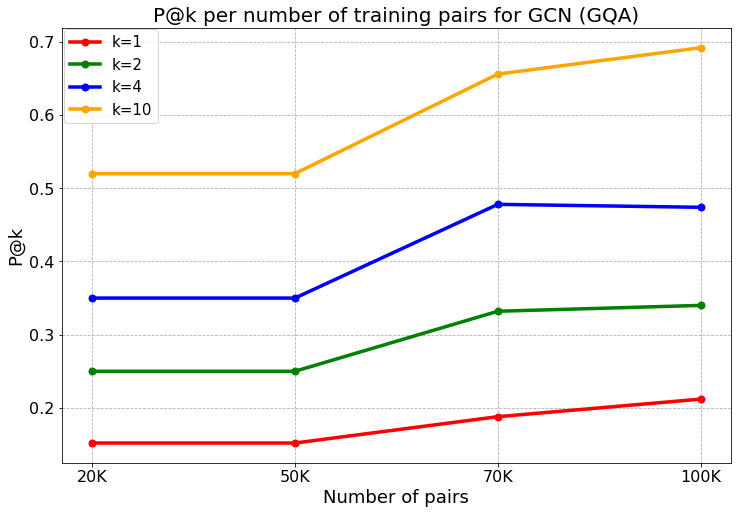

In [264]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
plt.title('P@k per number of training pairs for GCN (GQA)', fontsize=20)
plt.plot(gcn1, color='red', label='k=1', marker="o", linewidth=3.5,markersize=7)
plt.plot(gcn2, color='green', label='k=2', marker="o", linewidth=3.5,markersize=7)
plt.plot(gcn4, color='blue', label='k=4', marker="o", linewidth=3.5,markersize=7)
plt.plot(gcn10, color='orange', label='k=10', marker="o", linewidth=3.5,markersize=7)

plt.grid(True, linestyle='--')
plt.ylabel('P@k', fontsize=18)
plt.xlabel('Number of pairs', fontsize=18)
#locs, labels = plt.xticks()
labels = ['20K', '50K', '70K', '100K']
plt.yticks(fontsize=16)
plt.xticks(np.arange(4), labels, fontsize=16)
plt.legend(fontsize=15, loc='upper left', bbox_to_anchor=(-0.008,1.015)) # , bbox_to_anchor=(0.5,0)
plt.show()

#Kernels

In [265]:
run_num=''

In [266]:
path = '/content/drive/MyDrive/data/kernel_outs/outs/outs' + run_num
sims = []
sims.append(pkl.load(open(path + '/sim500_wl.pkl', 'rb')))
sims.append(pkl.load(open(path + '/sim500_pm.pkl', 'rb')))
sims.append(pkl.load(open(path + '/sim500_pa_attr.pkl', 'rb')))
sims.append(pkl.load(open(path + '/sim500_sm_attr.pkl', 'rb')))
sims.append(pkl.load(open(path + '/sim500_gh_attr.pkl', 'rb')))

sims_rank = []
sims_rank.append(pkl.load(open(path + '/sim500_wl_rank.pkl', 'rb')))
sims_rank.append(pkl.load(open(path + '/sim500_pm_rank.pkl', 'rb')))
sims_rank.append(pkl.load(open(path + '/sim500_pa_attr_rank.pkl', 'rb')))
sims_rank.append(pkl.load(open(path + '/sim500_sm_attr_rank.pkl', 'rb')))
sims_rank.append(pkl.load(open(path + '/sim500_gh_attr_rank.pkl', 'rb')))

In [267]:
comp = []
for i in sims_rank:
  c = []
  for j in i:
    mj = max(j)
    new_j = j/mj
    c.append(new_j)

  comp.append(c)

In [268]:
emb_10_list = []
for i in range(len(comp)):
  emb_10 = find_all_similar(np.array(comp[i]))
  for idx in range(500):
    emb_10[idx] = [new_idxs[i][0] for i in emb_10[idx] ]
  emb_10 = [list(reversed(i)) for i in emb_10]
  emb_10_list.append(emb_10)

In [269]:
len(emb_10_list[0])

500

In [270]:
all_preds = []
for j in range(len(emb_10_list)):
  preds = []
  for i in range(500):
    idx = new_idxs[i][0]
    preds.append(get_rank_untargeted_class(idx, emb_10_list[j][i], class_dict)[:10])
  all_preds.append(preds)

In [271]:
hps, rbos, all_hps_list, all_rbos = score_stats([preds_gd[idx[0]][:10] for idx in new_idxs], all_preds)
hps_results['PM']=all_hps_list
rbo_results['PM']=all_rbos

---- k = 1 ----
(500, 1) (500, 1)
Hit Percentage: 0.06
Mean RBO: 0.06
(500, 1) (500, 1)
Hit Percentage: 0.104
Mean RBO: 0.104
(500, 1) (500, 1)
Hit Percentage: 0.046
Mean RBO: 0.046
(500, 1) (500, 1)
Hit Percentage: 0.068
Mean RBO: 0.068
(500, 1) (500, 1)
Hit Percentage: 0.014
Mean RBO: 0.014
---- k = 2 ----
(500, 2) (500, 2)
Hit Percentage: 0.092
Mean RBO: 0.076
(500, 2) (500, 2)
Hit Percentage: 0.123
Mean RBO: 0.1135
(500, 2) (500, 2)
Hit Percentage: 0.065
Mean RBO: 0.0555
(500, 2) (500, 2)
Hit Percentage: 0.086
Mean RBO: 0.077
(500, 2) (500, 2)
Hit Percentage: 0.018
Mean RBO: 0.016
---- k = 4 ----
(500, 4) (500, 4)
Hit Percentage: 0.114
Mean RBO: 0.09316666666666666
(500, 4) (500, 4)
Hit Percentage: 0.1515
Mean RBO: 0.1284583333333333
(500, 4) (500, 4)
Hit Percentage: 0.101
Mean RBO: 0.07249999999999998
(500, 4) (500, 4)
Hit Percentage: 0.1115
Mean RBO: 0.09154166666666666
(500, 4) (500, 4)
Hit Percentage: 0.019
Mean RBO: 0.017583333333333333
---- k = 10 ----
(500, 10) (500, 10)
Hit

In [272]:
ndcg_list = []
for k in [1,2,4,10]:
  print()
  print('--------{}--------'.format(k))
  for i in range(5):
    #[preds_gd[idx[0]][:10] for idx in new_idxs], all_preds
    n = compute_ndcg([preds_gd[idx[0]][:10] for idx in new_idxs], all_preds[i], k=k)
    print(n)
    if i==1:
      ndcg_list.append([k,n])
ndcg_results['PM'] = ndcg_list
ndcg_results


--------1--------
0.5886
0.6516000000000001
0.5734
0.5879000000000001
0.5574

--------2--------
0.6035673620115151
0.6530415598710977
0.5912075568940252
0.6046724417880726
0.5792496478477234

--------4--------
0.641946817640995
0.6758439132015205
0.6351168525090098
0.6421589097266339
0.6262232532861989

--------10--------
0.844165049436069
0.8604069323173423
0.840522171158802
0.8442132319717962
0.8363130698929204


{'GCN-20K': [[1, 0.6691],
  [2, 0.6876198412844279],
  [4, 0.7049684529853926],
  [10, 0.8721760587732037]],
 'GCN-50K': [[1, 0.7217],
  [2, 0.7195237990407468],
  [4, 0.7279639314071898],
  [10, 0.8837939918725795]],
 'GCN-70K': [[1, 0.7249],
  [2, 0.7297652645649548],
  [4, 0.7403696724487302],
  [10, 0.8881516007548524]],
 'GCN-100K': [[1, 0.7283000000000001],
  [2, 0.7353678464275563],
  [4, 0.7437160751416496],
  [10, 0.8898420850669181]],
 'GIN-20K': [[1, 0.669],
  [2, 0.6651859473633798],
  [4, 0.6883481259358096],
  [10, 0.8661058081170658]],
 'GIN-50K': [[1, 0.6782999999999999],
  [2, 0.6862710570167676],
  [4, 0.7054450173977794],
  [10, 0.8727363093695554]],
 'GIN-70K': [[1, 0.6966000000000001],
  [2, 0.6991996368146906],
  [4, 0.7206024687874087],
  [10, 0.8785650591432068]],
 'GIN-100K': [[1, 0.7203],
  [2, 0.7086865897853534],
  [4, 0.7239155591565003],
  [10, 0.8818834767557872]],
 'GAT-20K': [[1, 0.663],
  [2, 0.6713658762990813],
  [4, 0.6937238622179881],
  [10, 0.867

In [273]:
ndcg_list_2 = []
for k in [1,2,4,10]:
  print()
  print('--------{}--------'.format(k))
  for i in range(5):
    n = compute_ndcg_2([preds_gd[idx[0]][:10] for idx in new_idxs], all_preds[i], k=k)
    print(n)
    if i==1:
      ndcg_list_2.append([k,n])
ndcg_results_2['PM'] = ndcg_list_2


--------1--------
0.12560000000000002
0.16460000000000002
0.11740000000000002
0.1338
0.1086

--------2--------
0.18689833072476472
0.22316430179262173
0.17927317783357427
0.19452348361595517
0.17109008692595523

--------4--------
0.2773187287669174
0.30955176808312307
0.27054152562863826
0.28409593190519655
0.2632684295778021

--------10--------
0.4698764761360499
0.493521052337667
0.4649050524218637
0.474847899850236
0.4595698659968833


In [274]:
prec_list = []
for k in [1,2,4,10]:
  print()
  print('--------{}--------'.format(k))
  for i in range(5):
    pr = np.mean([precision_k(b,c, k=k) for b,c in zip([preds_gd[idx[0]][:10] for idx in new_idxs], all_preds[i])])
    print(pr)
    if i==1:
      prec_list.append([k, pr])
precision_results['PM']=prec_list


--------1--------
0.06
0.104
0.046
0.068
0.014

--------2--------
0.088
0.146
0.074
0.102
0.022

--------4--------
0.118
0.202
0.104
0.14
0.026

--------10--------
0.166
0.316
0.174
0.198
0.032


In [275]:
for k1, i1, i2, i3, i4 in zip(precision_results.keys(), hps_results.values(), ndcg_results.values(),  precision_results.values(), ndcg_results_2.values()):
  print('\small',k1, "& \small {0:0.3f} &".format(i1[0][1]), " \small {0:0.3f} &".format(i1[1][1]),  " \small {0:0.3f} &".format(i1[2][1]),  " \small {0:0.3f} &".format(i1[3][1]), " \small {0:0.3f} &".format(i2[0][1]), " \small {0:0.3f} &".format(i2[1][1]),  " \small {0:0.3f} &".format(i2[2][1]),  " \small {0:0.3f} &".format(i2[3][1]),
        " \small {0:0.3f} &".format(i3[0][1]), " \small {0:0.3f} &".format(i3[1][1]),  " \small {0:0.3f} &".format(i3[2][1]),  " \small {0:0.3f} &".format(i3[3][1]), " \small {0:0.3f} &".format(i4[0][1]), " \small {0:0.3f} &".format(i4[1][1]),  " \small {0:0.3f} &".format(i4[2][1]),  " \small {0:0.3f} \\\\".format(i4[3][1]))    

\small GCN-20K & \small 0.152 &  \small 0.225 &  \small 0.267 &  \small 0.365 &  \small 0.669 &  \small 0.688 &  \small 0.705 &  \small 0.872 &  \small 0.152 &  \small 0.250 &  \small 0.350 &  \small 0.520 &  \small 0.195 &  \small 0.251 &  \small 0.334 &  \small 0.512 \\
\small GCN-50K & \small 0.188 &  \small 0.258 &  \small 0.321 &  \small 0.407 &  \small 0.722 &  \small 0.720 &  \small 0.728 &  \small 0.884 &  \small 0.152 &  \small 0.250 &  \small 0.350 &  \small 0.520 &  \small 0.223 &  \small 0.278 &  \small 0.358 &  \small 0.529 \\
\small GCN-70K & \small 0.188 &  \small 0.286 &  \small 0.341 &  \small 0.430 &  \small 0.725 &  \small 0.730 &  \small 0.740 &  \small 0.888 &  \small 0.188 &  \small 0.332 &  \small 0.478 &  \small 0.656 &  \small 0.221 &  \small 0.276 &  \small 0.356 &  \small 0.528 \\
\small GCN-100K & \small 0.212 &  \small 0.297 &  \small 0.348 &  \small 0.439 &  \small 0.728 &  \small 0.735 &  \small 0.744 &  \small 0.890 &  \small 0.212 &  \small 0.340 &  \sm

#VG-random

In [276]:
import pickle as pkl

In [277]:
new_idxs = pkl.load(open(pth+'scene500_large_random_idx.pkl', 'rb'))
image_ids_vg_dense = pkl.load(open(pth+'images_ids_vg_random.pkl', 'rb'))
vg_dense_classification = pkl.load(open(pth+'vg_random.pkl', 'rb'))

In [278]:
syn_n = pkl.load(open(pth+'syn_n500_random.pkl', 'rb'))

In [279]:
geds = pkl.load(open(pth+'geds_bipartite_costs_random.pkl', 'rb'))

In [280]:
vg_dense_classification

vg_id               label  label_prob
0       12         home_office    0.403223
1       31       chemistry_lab    0.163597
2       39         dining_room    0.211453
3       56           shopfront    0.274534
4       79     conference_room    0.306599
..     ...                 ...         ...
495   3055    airport_terminal    0.216154
496   3057       church/indoor    0.123744
497   3058  bus_station/indoor    0.453846
498   3061           promenade    0.207664
499   3062           crosswalk    0.180144

[500 rows x 3 columns]

In [281]:
len(vg_dense_classification.label.unique())

156

In [282]:
[int(i) for i in image_ids_vg_dense] == list(vg_dense_classification['vg_id'])

True

In [283]:
gd_rank = find_all(geds, [i[0] for i in new_idxs])

In [284]:
gd = []
for idx in new_idxs:
  gd.append(gd_rank[idx[0]])

In [285]:
class_dict =  dict()
for i in range(len(new_idxs)):
  class_dict[new_idxs[i][0]] = vg_dense_classification.iloc[[i]]['label'].item()

In [286]:
preds_gd = {}
for i in range(500):
  idx = new_idxs[i][0]
  preds_gd[idx] = get_rank_untargeted_class(idx, gd[i], class_dict)

In [287]:
confident_rows = vg_dense_classification.loc[(vg_dense_classification['label_prob'] >= 0.5)]
confident_ids = list(confident_rows['vg_id'])

In [288]:
confident_ids_to_idx = [new_idxs[image_ids_vg_dense.index(i)][0] for i in confident_ids]

In [289]:
len(confident_ids_to_idx)

77

#GCN 20K

In [290]:
hps_results = {}
rbo_results = {}
ndcg_results = {}
precision_results = {}
ndcg_results_2 = {}


In [291]:
import numpy as np
embeddings_res = np.array(pkl.load(open(pth+'emb_gcn_random_20k.pkl', 'rb')))

In [292]:
from tqdm import tqdm
from scipy import spatial

comp = []
for value in tqdm(range(embeddings_res.shape[0])):
  emb_comp = []
  for i in range(embeddings_res.shape[0]):
    emb_comp.append(1 - spatial.distance.cosine(embeddings_res[value], embeddings_res[i]))

  comp.append([i/max(emb_comp) for i in emb_comp])

emb_10 = find_all_similar(np.array(comp))
for idx in range(500):
  emb_10[idx] = [new_idxs[i][0] for i in emb_10[idx] ]

emb_10 = [list(reversed(i)) for i in emb_10]

100%|██████████| 500/500 [00:28<00:00, 17.34it/s]


In [293]:
preds = {}
for i in range(500):
  idx = new_idxs[i][0]
  preds[idx] = get_rank_untargeted_class(idx, emb_10[i], class_dict)

In [294]:
amount=500

In [295]:
hps, rbos, all_hps_list, all_rbos = score_stats([preds_gd[idx[0]][:10] for idx in new_idxs], [[preds[idx[0]][:10] for idx in new_idxs]])
hps_results['GCN-20K']=all_hps_list
rbo_results['GCN-20K']=all_rbos

---- k = 1 ----
(500, 1) (500, 1)
Hit Percentage: 0.136
Mean RBO: 0.136
---- k = 2 ----
(500, 2) (500, 2)
Hit Percentage: 0.159
Mean RBO: 0.1475
---- k = 4 ----
(500, 4) (500, 4)
Hit Percentage: 0.2105
Mean RBO: 0.17354166666666665
---- k = 10 ----
(500, 10) (500, 10)
Hit Percentage: 0.29419999999999996
Mean RBO: 0.22864214285714285


In [296]:
ndcg_list = []
for k in [1,2,4,10]:
  print()
  print('--------{}--------'.format(k))
  for i in range(len([emb_10])):
    n = compute_ndcg([preds_gd[idx[0]][:10] for idx in new_idxs], [preds[idx[0]][:10] for idx in new_idxs], k=k)
    print(n)
    ndcg_list.append([k,n])
ndcg_results['GCN-20K'] = ndcg_list


--------1--------
0.6614000000000001

--------2--------
0.6621002117736162

--------4--------
0.6868897082420824

--------10--------
0.864844084943325


In [297]:
ndcg_list_2 = []
for k in [1,2,4,10]:
  print()
  print('--------{}--------'.format(k))
  for i in range(len([emb_10])):
    n = compute_ndcg_2([preds_gd[idx[0]][:10] for idx in new_idxs], [preds[idx[0]][:10] for idx in new_idxs], k=k)
    print(n)
    ndcg_list_2.append([k,n])
ndcg_results_2['GCN-20K'] = ndcg_list_2


--------1--------
0.1882

--------2--------
0.24510986377214544

--------4--------
0.3290568893103655

--------10--------
0.5078290522955687


In [298]:
prec_list = []
for k in [1,2,4,10]:
  print()
  print('--------{}--------'.format(k))
  for i in range(len([emb_10])):
    pr = np.mean([precision_k(b,c, k=k) for b,c in zip([preds_gd[idx[0]][:10] for idx in new_idxs], [preds[idx[0]][:10] for idx in new_idxs])])
    print(pr)
    prec_list.append([k, pr])
precision_results['GCN-20K']=prec_list


--------1--------
0.136

--------2--------
0.202

--------4--------
0.28

--------10--------
0.394


#GCN 50K

In [299]:
import numpy as np
embeddings_res = np.array(pkl.load(open(pth+'emb_gcn_random_50k.pkl', 'rb')))

In [300]:
from tqdm import tqdm
from scipy import spatial

comp = []
for value in tqdm(range(embeddings_res.shape[0])):
  emb_comp = []
  for i in range(embeddings_res.shape[0]):
    emb_comp.append(1 - spatial.distance.cosine(embeddings_res[value], embeddings_res[i]))

  comp.append([i/max(emb_comp) for i in emb_comp])

emb_10 = find_all_similar(np.array(comp))
for idx in range(500):
  emb_10[idx] = [new_idxs[i][0] for i in emb_10[idx] ]

emb_10 = [list(reversed(i)) for i in emb_10]

100%|██████████| 500/500 [00:32<00:00, 15.21it/s]


In [301]:
preds = {}
for i in range(500):
  idx = new_idxs[i][0]
  preds[idx] = get_rank_untargeted_class(idx, emb_10[i], class_dict)

In [302]:
amount=500

In [303]:
hps, rbos, all_hps_list, all_rbos = score_stats([preds_gd[idx[0]][:10] for idx in new_idxs], [[preds[idx[0]][:10] for idx in new_idxs]])
hps_results['GCN-50K']=all_hps_list
rbo_results['GCN-50K']=all_rbos

---- k = 1 ----
(500, 1) (500, 1)
Hit Percentage: 0.166
Mean RBO: 0.166
---- k = 2 ----
(500, 2) (500, 2)
Hit Percentage: 0.224
Mean RBO: 0.195
---- k = 4 ----
(500, 4) (500, 4)
Hit Percentage: 0.2695
Mean RBO: 0.226875
---- k = 10 ----
(500, 10) (500, 10)
Hit Percentage: 0.35660000000000003
Mean RBO: 0.2885706349206349


In [304]:
ndcg_list = []
for k in [1,2,4,10]:
  print()
  print('--------{}--------'.format(k))
  for i in range(len([emb_10])):
    n = compute_ndcg([preds_gd[idx[0]][:10] for idx in new_idxs], [preds[idx[0]][:10] for idx in new_idxs], k=k)
    print(n)
    ndcg_list.append([k,n])
ndcg_results['GCN-50K'] = ndcg_list


--------1--------
0.6961

--------2--------
0.6936000740572867

--------4--------
0.7143925766400104

--------10--------
0.8765138866582525


In [305]:
ndcg_list_2 = []
for k in [1,2,4,10]:
  print()
  print('--------{}--------'.format(k))
  for i in range(len([emb_10])):
    n = compute_ndcg_2([preds_gd[idx[0]][:10] for idx in new_idxs], [preds[idx[0]][:10] for idx in new_idxs], k=k)
    print(n)
    ndcg_list_2.append([k,n])
ndcg_results_2['GCN-50K'] = ndcg_list_2


--------1--------
0.2084

--------2--------
0.2638937769919073

--------4--------
0.3457519506997848

--------10--------
0.520075730225637


In [306]:
prec_list = []
for k in [1,2,4,10]:
  print()
  print('--------{}--------'.format(k))
  for i in range(len([emb_10])):
    pr = np.mean([precision_k(b,c, k=k) for b,c in zip([preds_gd[idx[0]][:10] for idx in new_idxs], [preds[idx[0]][:10] for idx in new_idxs])])
    print(pr)
    prec_list.append([k, pr])
precision_results['GCN-50K']=prec_list


--------1--------
0.166

--------2--------
0.256

--------4--------
0.38

--------10--------
0.514


#GCN 70K

In [307]:
import numpy as np
embeddings_res = np.array(pkl.load(open(pth+'emb_gcn_random_70k.pkl', 'rb')))

In [308]:
from tqdm import tqdm
from scipy import spatial

comp = []
for value in tqdm(range(embeddings_res.shape[0])):
  emb_comp = []
  for i in range(embeddings_res.shape[0]):
    emb_comp.append(1 - spatial.distance.cosine(embeddings_res[value], embeddings_res[i]))

  comp.append([i/max(emb_comp) for i in emb_comp])

emb_10 = find_all_similar(np.array(comp))
for idx in range(500):
  emb_10[idx] = [new_idxs[i][0] for i in emb_10[idx] ]

emb_10 = [list(reversed(i)) for i in emb_10]

100%|██████████| 500/500 [00:28<00:00, 17.56it/s]


In [309]:
preds = {}
for i in range(500):
  idx = new_idxs[i][0]
  preds[idx] = get_rank_untargeted_class(idx, emb_10[i], class_dict)

In [310]:
amount=500

In [311]:
hps, rbos, all_hps_list, all_rbos = score_stats([preds_gd[idx[0]][:10] for idx in new_idxs], [[preds[idx[0]][:10] for idx in new_idxs]])
hps_results['GCN-70K']=all_hps_list
rbo_results['GCN-70K']=all_rbos

---- k = 1 ----
(500, 1) (500, 1)
Hit Percentage: 0.214
Mean RBO: 0.214
---- k = 2 ----
(500, 2) (500, 2)
Hit Percentage: 0.249
Mean RBO: 0.2315
---- k = 4 ----
(500, 4) (500, 4)
Hit Percentage: 0.3
Mean RBO: 0.26275
---- k = 10 ----
(500, 10) (500, 10)
Hit Percentage: 0.385
Mean RBO: 0.3175126984126984


In [312]:
ndcg_list = []
for k in [1,2,4,10]:
  print()
  print('--------{}--------'.format(k))
  for i in range(len([emb_10])):
    n = compute_ndcg([preds_gd[idx[0]][:10] for idx in new_idxs], [preds[idx[0]][:10] for idx in new_idxs], k=k)
    print(n)
    ndcg_list.append([k,n])
ndcg_results['GCN-70K'] = ndcg_list


--------1--------
0.6972

--------2--------
0.7011472985552266

--------4--------
0.7148889881935738

--------10--------
0.8777872591458148


In [313]:
ndcg_list_2 = []
for k in [1,2,4,10]:
  print()
  print('--------{}--------'.format(k))
  for i in range(len([emb_10])):
    n = compute_ndcg_2([preds_gd[idx[0]][:10] for idx in new_idxs], [preds[idx[0]][:10] for idx in new_idxs], k=k)
    print(n)
    ndcg_list_2.append([k,n])
ndcg_results_2['GCN-70K'] = ndcg_list_2


--------1--------
0.24980000000000002

--------2--------
0.3023915001254786

--------4--------
0.37996856166621845

--------10--------
0.5451753572704308


In [314]:
prec_list = []
for k in [1,2,4,10]:
  print()
  print('--------{}--------'.format(k))
  for i in range(len([emb_10])):
    pr = np.mean([precision_k(b,c, k=k) for b,c in zip([preds_gd[idx[0]][:10] for idx in new_idxs], [preds[idx[0]][:10] for idx in new_idxs])])
    print(pr)
    prec_list.append([k, pr])
precision_results['GCN-70K']=prec_list


--------1--------
0.214

--------2--------
0.3

--------4--------
0.418

--------10--------
0.562


#GCN 100K

In [315]:
import numpy as np
embeddings_res = np.array(pkl.load(open(pth+'emb_gcn_random_100k.pkl', 'rb')))

In [316]:
from tqdm import tqdm
from scipy import spatial

comp = []
for value in tqdm(range(embeddings_res.shape[0])):
  emb_comp = []
  for i in range(embeddings_res.shape[0]):
    emb_comp.append(1 - spatial.distance.cosine(embeddings_res[value], embeddings_res[i]))

  comp.append([i/max(emb_comp) for i in emb_comp])

emb_10 = find_all_similar(np.array(comp))
for idx in range(500):
  emb_10[idx] = [new_idxs[i][0] for i in emb_10[idx] ]

emb_10 = [list(reversed(i)) for i in emb_10]

100%|██████████| 500/500 [00:28<00:00, 17.34it/s]


In [317]:
preds = {}
for i in range(500):
  idx = new_idxs[i][0]
  preds[idx] = get_rank_untargeted_class(idx, emb_10[i], class_dict)

In [318]:
amount=500

In [319]:
hps, rbos, all_hps_list, all_rbos = score_stats([preds_gd[idx[0]][:10] for idx in new_idxs], [[preds[idx[0]][:10] for idx in new_idxs]])
hps_results['GCN-100K']=all_hps_list
rbo_results['GCN-100K']=all_rbos

---- k = 1 ----
(500, 1) (500, 1)
Hit Percentage: 0.206
Mean RBO: 0.206
---- k = 2 ----
(500, 2) (500, 2)
Hit Percentage: 0.258
Mean RBO: 0.232
---- k = 4 ----
(500, 4) (500, 4)
Hit Percentage: 0.309
Mean RBO: 0.26675
---- k = 10 ----
(500, 10) (500, 10)
Hit Percentage: 0.3926
Mean RBO: 0.3281060317460317


In [320]:
ndcg_list = []
for k in [1,2,4,10]:
  print()
  print('--------{}--------'.format(k))
  for i in range(len([emb_10])):
    n = compute_ndcg([preds_gd[idx[0]][:10] for idx in new_idxs], [preds[idx[0]][:10] for idx in new_idxs], k=k)
    print(n)
    ndcg_list.append([k,n])
ndcg_results['GCN-100K'] = ndcg_list


--------1--------
0.7163999999999999

--------2--------
0.7116764768987978

--------4--------
0.7289491491766217

--------10--------
0.8834986408129876


In [321]:
ndcg_list_2 = []
for k in [1,2,4,10]:
  print()
  print('--------{}--------'.format(k))
  for i in range(len([emb_10])):
    n = compute_ndcg_2([preds_gd[idx[0]][:10] for idx in new_idxs], [preds[idx[0]][:10] for idx in new_idxs], k=k)
    print(n)
    ndcg_list_2.append([k,n])
ndcg_results_2['GCN-100K'] = ndcg_list_2


--------1--------
0.24020000000000002

--------2--------
0.29346449186262147

--------4--------
0.37203427506530634

--------10--------
0.5393551538977249


In [322]:
prec_list = []
for k in [1,2,4,10]:
  print()
  print('--------{}--------'.format(k))
  for i in range(len([emb_10])):
    pr = np.mean([precision_k(b,c, k=k) for b,c in zip([preds_gd[idx[0]][:10] for idx in new_idxs], [preds[idx[0]][:10] for idx in new_idxs])])
    print(pr)
    prec_list.append([k, pr])
precision_results['GCN-100K']=prec_list


--------1--------
0.206

--------2--------
0.302

--------4--------
0.432

--------10--------
0.572


#GAT 20K

In [323]:
import numpy as np
embeddings_res = np.array(pkl.load(open(pth+'emb_gat_random_20k.pkl', 'rb')))

In [324]:
from tqdm import tqdm
from scipy import spatial

comp = []
for value in tqdm(range(embeddings_res.shape[0])):
  emb_comp = []
  for i in range(embeddings_res.shape[0]):
    emb_comp.append(1 - spatial.distance.cosine(embeddings_res[value], embeddings_res[i]))

  comp.append([i/max(emb_comp) for i in emb_comp])

emb_10 = find_all_similar(np.array(comp))
for idx in range(500):
  emb_10[idx] = [new_idxs[i][0] for i in emb_10[idx] ]

emb_10 = [list(reversed(i)) for i in emb_10]

100%|██████████| 500/500 [00:33<00:00, 14.98it/s]


In [325]:
preds = {}
for i in range(500):
  idx = new_idxs[i][0]
  preds[idx] = get_rank_untargeted_class(idx, emb_10[i], class_dict)

In [326]:
amount=500

In [327]:
hps, rbos, all_hps_list, all_rbos = score_stats([preds_gd[idx[0]][:10] for idx in new_idxs], [[preds[idx[0]][:10] for idx in new_idxs]])
hps_results['GAT-20K']=all_hps_list
rbo_results['GAT-20K']=all_rbos

---- k = 1 ----
(500, 1) (500, 1)
Hit Percentage: 0.15
Mean RBO: 0.15
---- k = 2 ----
(500, 2) (500, 2)
Hit Percentage: 0.198
Mean RBO: 0.174
---- k = 4 ----
(500, 4) (500, 4)
Hit Percentage: 0.234
Mean RBO: 0.2
---- k = 10 ----
(500, 10) (500, 10)
Hit Percentage: 0.303
Mean RBO: 0.2462731746031746


In [328]:
ndcg_list = []
for k in [1,2,4,10]:
  print()
  print('--------{}--------'.format(k))
  for i in range(len([emb_10])):
    n = compute_ndcg([preds_gd[idx[0]][:10] for idx in new_idxs], [preds[idx[0]][:10] for idx in new_idxs], k=k)
    print(n)
    ndcg_list.append([k,n])
ndcg_results['GAT-20K'] = ndcg_list


--------1--------
0.6823

--------2--------
0.6799422626549944

--------4--------
0.6974992355879608

--------10--------
0.8701009184268919


In [329]:
ndcg_list_2 = []
for k in [1,2,4,10]:
  print()
  print('--------{}--------'.format(k))
  for i in range(len([emb_10])):
    n = compute_ndcg_2([preds_gd[idx[0]][:10] for idx in new_idxs], [preds[idx[0]][:10] for idx in new_idxs], k=k)
    print(n)
    ndcg_list_2.append([k,n])
ndcg_results_2['GAT-20K'] = ndcg_list_2


--------1--------
0.197

--------2--------
0.2532929546797645

--------4--------
0.33632998536120157

--------10--------
0.5131642387205491


In [330]:
prec_list = []
for k in [1,2,4,10]:
  print()
  print('--------{}--------'.format(k))
  for i in range(len([emb_10])):
    pr = np.mean([precision_k(b,c, k=k) for b,c in zip([preds_gd[idx[0]][:10] for idx in new_idxs], [preds[idx[0]][:10] for idx in new_idxs])])
    print(pr)
    prec_list.append([k, pr])
precision_results['GAT-20K']=prec_list


--------1--------
0.15

--------2--------
0.22

--------4--------
0.292

--------10--------
0.44


#GAT 50K

In [331]:
import numpy as np
embeddings_res = np.array(pkl.load(open(pth+'emb_gat_random_50k.pkl', 'rb')))

In [332]:
from tqdm import tqdm
from scipy import spatial

comp = []
for value in tqdm(range(embeddings_res.shape[0])):
  emb_comp = []
  for i in range(embeddings_res.shape[0]):
    emb_comp.append(1 - spatial.distance.cosine(embeddings_res[value], embeddings_res[i]))

  comp.append([i/max(emb_comp) for i in emb_comp])

emb_10 = find_all_similar(np.array(comp))
for idx in range(500):
  emb_10[idx] = [new_idxs[i][0] for i in emb_10[idx] ]

emb_10 = [list(reversed(i)) for i in emb_10]

100%|██████████| 500/500 [00:33<00:00, 14.77it/s]


In [333]:
preds = {}
for i in range(500):
  idx = new_idxs[i][0]
  preds[idx] = get_rank_untargeted_class(idx, emb_10[i], class_dict)

In [334]:
amount=500

In [335]:
hps, rbos, all_hps_list, all_rbos = score_stats([preds_gd[idx[0]][:10] for idx in new_idxs], [[preds[idx[0]][:10] for idx in new_idxs]])
hps_results['GAT-50K']=all_hps_list
rbo_results['GAT-50K']=all_rbos

---- k = 1 ----
(500, 1) (500, 1)
Hit Percentage: 0.176
Mean RBO: 0.176
---- k = 2 ----
(500, 2) (500, 2)
Hit Percentage: 0.23
Mean RBO: 0.203
---- k = 4 ----
(500, 4) (500, 4)
Hit Percentage: 0.2775
Mean RBO: 0.23354166666666662
---- k = 10 ----
(500, 10) (500, 10)
Hit Percentage: 0.36279999999999996
Mean RBO: 0.29294944444444443


In [336]:
ndcg_list = []
for k in [1,2,4,10]:
  print()
  print('--------{}--------'.format(k))
  for i in range(len([emb_10])):
    n = compute_ndcg([preds_gd[idx[0]][:10] for idx in new_idxs], [preds[idx[0]][:10] for idx in new_idxs], k=k)
    print(n)
    ndcg_list.append([k,n])
ndcg_results['GAT-50K'] = ndcg_list


--------1--------
0.6897000000000001

--------2--------
0.6871571491976015

--------4--------
0.7088326011442696

--------10--------
0.8742404856972257


In [337]:
ndcg_list_2 = []
for k in [1,2,4,10]:
  print()
  print('--------{}--------'.format(k))
  for i in range(len([emb_10])):
    n = compute_ndcg_2([preds_gd[idx[0]][:10] for idx in new_idxs], [preds[idx[0]][:10] for idx in new_idxs], k=k)
    print(n)
    ndcg_list_2.append([k,n])
ndcg_results_2['GAT-50K'] = ndcg_list_2


--------1--------
0.21320000000000003

--------2--------
0.26835728112333584

--------4--------
0.3497190940002409

--------10--------
0.52298583191199


In [338]:
prec_list = []
for k in [1,2,4,10]:
  print()
  print('--------{}--------'.format(k))
  for i in range(len([emb_10])):
    pr = np.mean([precision_k(b,c, k=k) for b,c in zip([preds_gd[idx[0]][:10] for idx in new_idxs], [preds[idx[0]][:10] for idx in new_idxs])])
    print(pr)
    prec_list.append([k, pr])
precision_results['GAT-50K']=prec_list


--------1--------
0.176

--------2--------
0.264

--------4--------
0.364

--------10--------
0.522


#GAT 70K

In [339]:
import numpy as np
embeddings_res = np.array(pkl.load(open(pth+'emb_gat_random_70k.pkl', 'rb')))

In [340]:
from tqdm import tqdm
from scipy import spatial

comp = []
for value in tqdm(range(embeddings_res.shape[0])):
  emb_comp = []
  for i in range(embeddings_res.shape[0]):
    emb_comp.append(1 - spatial.distance.cosine(embeddings_res[value], embeddings_res[i]))

  comp.append([i/max(emb_comp) for i in emb_comp])

emb_10 = find_all_similar(np.array(comp))
for idx in range(500):
  emb_10[idx] = [new_idxs[i][0] for i in emb_10[idx] ]

emb_10 = [list(reversed(i)) for i in emb_10]

100%|██████████| 500/500 [00:53<00:00,  9.32it/s]


In [341]:
preds = {}
for i in range(500):
  idx = new_idxs[i][0]
  preds[idx] = get_rank_untargeted_class(idx, emb_10[i], class_dict)

In [342]:
amount=500

In [343]:
hps, rbos, all_hps_list, all_rbos = score_stats([preds_gd[idx[0]][:10] for idx in new_idxs], [[preds[idx[0]][:10] for idx in new_idxs]])
hps_results['GAT-70K']=all_hps_list
rbo_results['GAT-70K']=all_rbos

---- k = 1 ----
(500, 1) (500, 1)
Hit Percentage: 0.184
Mean RBO: 0.184
---- k = 2 ----
(500, 2) (500, 2)
Hit Percentage: 0.244
Mean RBO: 0.214
---- k = 4 ----
(500, 4) (500, 4)
Hit Percentage: 0.288
Mean RBO: 0.24583333333333332
---- k = 10 ----
(500, 10) (500, 10)
Hit Percentage: 0.377
Mean RBO: 0.3052371428571429


In [344]:
ndcg_list_2 = []
for k in [1,2,4,10]:
  print()
  print('--------{}--------'.format(k))
  for i in range(len([emb_10])):
    n = compute_ndcg_2([preds_gd[idx[0]][:10] for idx in new_idxs], [preds[idx[0]][:10] for idx in new_idxs], k=k)
    print(n)
    ndcg_list_2.append([k,n])
ndcg_results_2['GAT-70K'] = ndcg_list_2


--------1--------
0.22240000000000004

--------2--------
0.2769123307085739

--------4--------
0.357322785326115

--------10--------
0.5285635268108331


In [345]:
ndcg_list = []
for k in [1,2,4,10]:
  print()
  print('--------{}--------'.format(k))
  for i in range(len([emb_10])):
    n = compute_ndcg([preds_gd[idx[0]][:10] for idx in new_idxs], [preds[idx[0]][:10] for idx in new_idxs], k=k)
    print(n)
    ndcg_list.append([k,n])
ndcg_results['GAT-70K'] = ndcg_list


--------1--------
0.696

--------2--------
0.6963040510894375

--------4--------
0.713241085701153

--------10--------
0.8765823688666473


In [346]:
prec_list = []
for k in [1,2,4,10]:
  print()
  print('--------{}--------'.format(k))
  for i in range(len([emb_10])):
    pr = np.mean([precision_k(b,c, k=k) for b,c in zip([preds_gd[idx[0]][:10] for idx in new_idxs], [preds[idx[0]][:10] for idx in new_idxs])])
    print(pr)
    prec_list.append([k, pr])
precision_results['GAT-70K']=prec_list


--------1--------
0.184

--------2--------
0.292

--------4--------
0.38

--------10--------
0.556


#GAT 100K

In [347]:
import numpy as np
embeddings_res = np.array(pkl.load(open(pth+'emb_gat_random_100k.pkl', 'rb')))

In [348]:
from tqdm import tqdm
from scipy import spatial

comp = []
for value in tqdm(range(embeddings_res.shape[0])):
  emb_comp = []
  for i in range(embeddings_res.shape[0]):
    emb_comp.append(1 - spatial.distance.cosine(embeddings_res[value], embeddings_res[i]))

  comp.append([i/max(emb_comp) for i in emb_comp])

emb_10 = find_all_similar(np.array(comp))
for idx in range(500):
  emb_10[idx] = [new_idxs[i][0] for i in emb_10[idx] ]

emb_10 = [list(reversed(i)) for i in emb_10]

100%|██████████| 500/500 [00:33<00:00, 14.88it/s]


In [349]:
preds = {}
for i in range(500):
  idx = new_idxs[i][0]
  preds[idx] = get_rank_untargeted_class(idx, emb_10[i], class_dict)

In [350]:
amount=500

In [351]:
hps, rbos, all_hps_list, all_rbos = score_stats([preds_gd[idx[0]][:10] for idx in new_idxs], [[preds[idx[0]][:10] for idx in new_idxs]])
hps_results['GAT-100K']=all_hps_list
rbo_results['GAT-100K']=all_rbos

---- k = 1 ----
(500, 1) (500, 1)
Hit Percentage: 0.244
Mean RBO: 0.244
---- k = 2 ----
(500, 2) (500, 2)
Hit Percentage: 0.26
Mean RBO: 0.252
---- k = 4 ----
(500, 4) (500, 4)
Hit Percentage: 0.295
Mean RBO: 0.26941666666666664
---- k = 10 ----
(500, 10) (500, 10)
Hit Percentage: 0.38480000000000003
Mean RBO: 0.32149873015873015


In [352]:
ndcg_list = []
for k in [1,2,4,10]:
  print()
  print('--------{}--------'.format(k))
  for i in range(len([emb_10])):
    n = compute_ndcg([preds_gd[idx[0]][:10] for idx in new_idxs], [preds[idx[0]][:10] for idx in new_idxs], k=k)
    print(n)
    ndcg_list.append([k,n])
ndcg_results['GAT-100K'] = ndcg_list


--------1--------
0.7192000000000001

--------2--------
0.7095723116797532

--------4--------
0.7176319537114989

--------10--------
0.8806589452467505


In [353]:
ndcg_list_2 = []
for k in [1,2,4,10]:
  print()
  print('--------{}--------'.format(k))
  for i in range(len([emb_10])):
    n = compute_ndcg_2([preds_gd[idx[0]][:10] for idx in new_idxs], [preds[idx[0]][:10] for idx in new_idxs], k=k)
    print(n)
    ndcg_list_2.append([k,n])
ndcg_results_2['GAT-100K'] = ndcg_list_2


--------1--------
0.2784

--------2--------
0.3289865455752404

--------4--------
0.40360612383143596

--------10--------
0.5625147131516166


In [354]:
prec_list = []
for k in [1,2,4,10]:
  print()
  print('--------{}--------'.format(k))
  for i in range(len([emb_10])):
    pr = np.mean([precision_k(b,c, k=k) for b,c in zip([preds_gd[idx[0]][:10] for idx in new_idxs], [preds[idx[0]][:10] for idx in new_idxs])])
    print(pr)
    prec_list.append([k, pr])
precision_results['GAT-100K']=prec_list


--------1--------
0.244

--------2--------
0.336

--------4--------
0.428

--------10--------
0.602


#GIN 20K

In [355]:
import numpy as np
embeddings_res = np.array(pkl.load(open(pth+'emb_gin_random_20k.pkl', 'rb')))

In [356]:
from tqdm import tqdm
from scipy import spatial

comp = []
for value in tqdm(range(embeddings_res.shape[0])):
  emb_comp = []
  for i in range(embeddings_res.shape[0]):
    emb_comp.append(1 - spatial.distance.cosine(embeddings_res[value], embeddings_res[i]))

  comp.append([i/max(emb_comp) for i in emb_comp])

emb_10 = find_all_similar(np.array(comp))
for idx in range(500):
  emb_10[idx] = [new_idxs[i][0] for i in emb_10[idx] ]

emb_10 = [list(reversed(i)) for i in emb_10]

100%|██████████| 500/500 [00:31<00:00, 16.05it/s]


In [357]:
preds = {}
for i in range(500):
  idx = new_idxs[i][0]
  preds[idx] = get_rank_untargeted_class(idx, emb_10[i], class_dict)

In [358]:
amount=500

In [359]:
hps, rbos, all_hps_list, all_rbos = score_stats([preds_gd[idx[0]][:10] for idx in new_idxs], [[preds[idx[0]][:10] for idx in new_idxs]])
hps_results['GIN-20K']=all_hps_list
rbo_results['GIN-20K']=all_rbos

---- k = 1 ----
(500, 1) (500, 1)
Hit Percentage: 0.066
Mean RBO: 0.066
---- k = 2 ----
(500, 2) (500, 2)
Hit Percentage: 0.079
Mean RBO: 0.0725
---- k = 4 ----
(500, 4) (500, 4)
Hit Percentage: 0.1165
Mean RBO: 0.09020833333333332
---- k = 10 ----
(500, 10) (500, 10)
Hit Percentage: 0.17320000000000002
Mean RBO: 0.12693920634920636


In [360]:
ndcg_list = []
for k in [1,2,4,10]:
  print()
  print('--------{}--------'.format(k))
  for i in range(len([emb_10])):
    n = compute_ndcg([preds_gd[idx[0]][:10] for idx in new_idxs], [preds[idx[0]][:10] for idx in new_idxs], k=k)
    print(n)
    ndcg_list.append([k,n])
ndcg_results['GIN-20K'] = ndcg_list


--------1--------
0.5967

--------2--------
0.606386262868359

--------4--------
0.6445179703491696

--------10--------
0.8455388403811771


In [361]:
ndcg_list_2 = []
for k in [1,2,4,10]:
  print()
  print('--------{}--------'.format(k))
  for i in range(len([emb_10])):
    n = compute_ndcg_2([preds_gd[idx[0]][:10] for idx in new_idxs], [preds[idx[0]][:10] for idx in new_idxs], k=k)
    print(n)
    ndcg_list_2.append([k,n])
ndcg_results_2['GIN-20K'] = ndcg_list_2


--------1--------
0.1338

--------2--------
0.19452348361595517

--------4--------
0.2840959319051966

--------10--------
0.47484789985023607


In [362]:
prec_list = []
for k in [1,2,4,10]:
  print()
  print('--------{}--------'.format(k))
  for i in range(len([emb_10])):
    pr = np.mean([precision_k(b,c, k=k) for b,c in zip([preds_gd[idx[0]][:10] for idx in new_idxs], [preds[idx[0]][:10] for idx in new_idxs])])
    print(pr)
    prec_list.append([k, pr])
precision_results['GIN-20K']=prec_list


--------1--------
0.066

--------2--------
0.094

--------4--------
0.152

--------10--------
0.234


#GIN 50K

In [363]:
import numpy as np
embeddings_res = np.array(pkl.load(open(pth+'emb_gin_random_50k.pkl', 'rb')))

In [364]:
from tqdm import tqdm
from scipy import spatial

comp = []
for value in tqdm(range(embeddings_res.shape[0])):
  emb_comp = []
  for i in range(embeddings_res.shape[0]):
    emb_comp.append(1 - spatial.distance.cosine(embeddings_res[value], embeddings_res[i]))

  comp.append([i/max(emb_comp) for i in emb_comp])

emb_10 = find_all_similar(np.array(comp))
for idx in range(500):
  emb_10[idx] = [new_idxs[i][0] for i in emb_10[idx] ]

emb_10 = [list(reversed(i)) for i in emb_10]

100%|██████████| 500/500 [00:29<00:00, 16.78it/s]


In [365]:
preds = {}
for i in range(500):
  idx = new_idxs[i][0]
  preds[idx] = get_rank_untargeted_class(idx, emb_10[i], class_dict)

In [366]:
amount=500

In [367]:
hps, rbos, all_hps_list, all_rbos = score_stats([preds_gd[idx[0]][:10] for idx in new_idxs], [[preds[idx[0]][:10] for idx in new_idxs]])
hps_results['GIN-50K']=all_hps_list
rbo_results['GIN-50K']=all_rbos

---- k = 1 ----
(500, 1) (500, 1)
Hit Percentage: 0.072
Mean RBO: 0.072
---- k = 2 ----
(500, 2) (500, 2)
Hit Percentage: 0.092
Mean RBO: 0.082
---- k = 4 ----
(500, 4) (500, 4)
Hit Percentage: 0.1305
Mean RBO: 0.10212499999999998
---- k = 10 ----
(500, 10) (500, 10)
Hit Percentage: 0.217
Mean RBO: 0.1539711111111111


In [368]:
ndcg_list = []
for k in [1,2,4,10]:
  print()
  print('--------{}--------'.format(k))
  for i in range(len([emb_10])):
    n = compute_ndcg([preds_gd[idx[0]][:10] for idx in new_idxs], [preds[idx[0]][:10] for idx in new_idxs], k=k)
    print(n)
    ndcg_list.append([k,n])
ndcg_results['GIN-50K'] = ndcg_list


--------1--------
0.5921

--------2--------
0.6080130503264567

--------4--------
0.6497327479717329

--------10--------
0.8466692776075506


In [369]:
ndcg_list_2 = []
for k in [1,2,4,10]:
  print()
  print('--------{}--------'.format(k))
  for i in range(len([emb_10])):
    n = compute_ndcg_2([preds_gd[idx[0]][:10] for idx in new_idxs], [preds[idx[0]][:10] for idx in new_idxs], k=k)
    print(n)
    ndcg_list_2.append([k,n])
ndcg_results_2['GIN-50K'] = ndcg_list_2


--------1--------
0.13300000000000003

--------2--------
0.19377956626071707

--------4--------
0.28343474135512053

--------10--------
0.4743628829025106


In [370]:
prec_list = []
for k in [1,2,4,10]:
  print()
  print('--------{}--------'.format(k))
  for i in range(len([emb_10])):
    pr = np.mean([precision_k(b,c, k=k) for b,c in zip([preds_gd[idx[0]][:10] for idx in new_idxs], [preds[idx[0]][:10] for idx in new_idxs])])
    print(pr)
    prec_list.append([k, pr])
precision_results['GIN-50K']=prec_list


--------1--------
0.072

--------2--------
0.102

--------4--------
0.142

--------10--------
0.262


#GIN 70K

In [371]:
import numpy as np
embeddings_res = np.array(pkl.load(open(pth+'emb_gin_random_70k.pkl', 'rb')))

In [372]:
from tqdm import tqdm
from scipy import spatial

comp = []
for value in tqdm(range(embeddings_res.shape[0])):
  emb_comp = []
  for i in range(embeddings_res.shape[0]):
    emb_comp.append(1 - spatial.distance.cosine(embeddings_res[value], embeddings_res[i]))

  comp.append([i/max(emb_comp) for i in emb_comp])

emb_10 = find_all_similar(np.array(comp))
for idx in range(500):
  emb_10[idx] = [new_idxs[i][0] for i in emb_10[idx] ]

emb_10 = [list(reversed(i)) for i in emb_10]

100%|██████████| 500/500 [00:28<00:00, 17.54it/s]


In [373]:
preds = {}
for i in range(500):
  idx = new_idxs[i][0]
  preds[idx] = get_rank_untargeted_class(idx, emb_10[i], class_dict)

In [374]:
amount=500

In [375]:
hps, rbos, all_hps_list, all_rbos = score_stats([preds_gd[idx[0]][:10] for idx in new_idxs], [[preds[idx[0]][:10] for idx in new_idxs]])
hps_results['GIN-70K']=all_hps_list
rbo_results['GIN-70K']=all_rbos

---- k = 1 ----
(500, 1) (500, 1)
Hit Percentage: 0.03
Mean RBO: 0.03
---- k = 2 ----
(500, 2) (500, 2)
Hit Percentage: 0.041
Mean RBO: 0.0355
---- k = 4 ----
(500, 4) (500, 4)
Hit Percentage: 0.065
Mean RBO: 0.0455
---- k = 10 ----
(500, 10) (500, 10)
Hit Percentage: 0.1108
Mean RBO: 0.07366396825396825


In [376]:
ndcg_list = []
for k in [1,2,4,10]:
  print()
  print('--------{}--------'.format(k))
  for i in range(len([emb_10])):
    n = compute_ndcg([preds_gd[idx[0]][:10] for idx in new_idxs], [preds[idx[0]][:10] for idx in new_idxs], k=k)
    print(n)
    ndcg_list.append([k,n])
ndcg_results['GIN-70K'] = ndcg_list


--------1--------
0.5685

--------2--------
0.5860477720661381

--------4--------
0.6283945030828115

--------10--------
0.8380723241054145


In [377]:
ndcg_list_2 = []
for k in [1,2,4,10]:
  print()
  print('--------{}--------'.format(k))
  for i in range(len([emb_10])):
    n = compute_ndcg_2([preds_gd[idx[0]][:10] for idx in new_idxs], [preds[idx[0]][:10] for idx in new_idxs], k=k)
    print(n)
    ndcg_list_2.append([k,n])
ndcg_results_2['GIN-70K'] = ndcg_list_2


--------1--------
0.11220000000000002

--------2--------
0.17443771502452665

--------4--------
0.2662437870531442

--------10--------
0.461752442261648


In [378]:
prec_list = []
for k in [1,2,4,10]:
  print()
  print('--------{}--------'.format(k))
  for i in range(len([emb_10])):
    pr = np.mean([precision_k(b,c, k=k) for b,c in zip([preds_gd[idx[0]][:10] for idx in new_idxs], [preds[idx[0]][:10] for idx in new_idxs])])
    print(pr)
    prec_list.append([k, pr])
precision_results['GIN-70K']=prec_list


--------1--------
0.03

--------2--------
0.046

--------4--------
0.068

--------10--------
0.128


#GIN 100K

In [379]:
import numpy as np
embeddings_res = np.array(pkl.load(open(pth+'emb_gin_random_100k.pkl', 'rb')))

In [380]:
from tqdm import tqdm
from scipy import spatial

comp = []
for value in tqdm(range(embeddings_res.shape[0])):
  emb_comp = []
  for i in range(embeddings_res.shape[0]):
    emb_comp.append(1 - spatial.distance.cosine(embeddings_res[value], embeddings_res[i]))

  comp.append([i/max(emb_comp) for i in emb_comp])

emb_10 = find_all_similar(np.array(comp))
for idx in range(500):
  emb_10[idx] = [new_idxs[i][0] for i in emb_10[idx] ]

emb_10 = [list(reversed(i)) for i in emb_10]

100%|██████████| 500/500 [00:28<00:00, 17.46it/s]


In [381]:
preds = {}
for i in range(500):
  idx = new_idxs[i][0]
  preds[idx] = get_rank_untargeted_class(idx, emb_10[i], class_dict)

In [382]:
amount=500

In [383]:
hps, rbos, all_hps_list, all_rbos = score_stats([preds_gd[idx[0]][:10] for idx in new_idxs], [[preds[idx[0]][:10] for idx in new_idxs]])
hps_results['GIN-100K']=all_hps_list
rbo_results['GIN-100K']=all_rbos

---- k = 1 ----
(500, 1) (500, 1)
Hit Percentage: 0.154
Mean RBO: 0.154
---- k = 2 ----
(500, 2) (500, 2)
Hit Percentage: 0.204
Mean RBO: 0.179
---- k = 4 ----
(500, 4) (500, 4)
Hit Percentage: 0.245
Mean RBO: 0.20575
---- k = 10 ----
(500, 10) (500, 10)
Hit Percentage: 0.3072
Mean RBO: 0.2534142857142857


In [384]:
ndcg_list = []
for k in [1,2,4,10]:
  print()
  print('--------{}--------'.format(k))
  for i in range(len([emb_10])):
    n = compute_ndcg([preds_gd[idx[0]][:10] for idx in new_idxs], [preds[idx[0]][:10] for idx in new_idxs], k=k)
    print(n)
    ndcg_list.append([k,n])
ndcg_results['GIN-100K'] = ndcg_list


--------1--------
0.6688

--------2--------
0.6739295207323922

--------4--------
0.6902936058457526

--------10--------
0.8672460263264262


In [385]:
ndcg_list_2 = []
for k in [1,2,4,10]:
  print()
  print('--------{}--------'.format(k))
  for i in range(len([emb_10])):
    n = compute_ndcg_2([preds_gd[idx[0]][:10] for idx in new_idxs], [preds[idx[0]][:10] for idx in new_idxs], k=k)
    print(n)
    ndcg_list_2.append([k,n])
ndcg_results_2['GIN-100K'] = ndcg_list_2


--------1--------
0.1952

--------2--------
0.25161914063047874

--------4--------
0.3348423066235306

--------10--------
0.5120729505881666


In [386]:
prec_list = []
for k in [1,2,4,10]:
  print()
  print('--------{}--------'.format(k))
  for i in range(len([emb_10])):
    pr = np.mean([precision_k(b,c, k=k) for b,c in zip([preds_gd[idx[0]][:10] for idx in new_idxs], [preds[idx[0]][:10] for idx in new_idxs])])
    print(pr)
    prec_list.append([k, pr])
precision_results['GIN-100K']=prec_list


--------1--------
0.154

--------2--------
0.226

--------4--------
0.296

--------10--------
0.428


In [387]:
for k1, i1, i2 in zip(precision_results.keys(), precision_results.values(), ndcg_results.values()):
  print(k1, "& {0:0.3f} &".format(i1[0][1]), "{0:0.3f} &".format(i1[1][1]),  "{0:0.3f} &".format(i1[2][1]),  "{0:0.3f} &".format(i1[3][1]), "{0:0.3f} &".format(i2[0][1]), "{0:0.3f} &".format(i2[1][1]),  "{0:0.3f} &".format(i2[2][1]),  "{0:0.3f} \\\\".format(i2[3][1]))    

GCN-20K & 0.136 & 0.202 & 0.280 & 0.394 & 0.661 & 0.662 & 0.687 & 0.865 \\
GCN-50K & 0.166 & 0.256 & 0.380 & 0.514 & 0.696 & 0.694 & 0.714 & 0.877 \\
GCN-70K & 0.214 & 0.300 & 0.418 & 0.562 & 0.697 & 0.701 & 0.715 & 0.878 \\
GCN-100K & 0.206 & 0.302 & 0.432 & 0.572 & 0.716 & 0.712 & 0.729 & 0.883 \\
GAT-20K & 0.150 & 0.220 & 0.292 & 0.440 & 0.682 & 0.680 & 0.697 & 0.870 \\
GAT-50K & 0.176 & 0.264 & 0.364 & 0.522 & 0.690 & 0.687 & 0.709 & 0.874 \\
GAT-70K & 0.184 & 0.292 & 0.380 & 0.556 & 0.696 & 0.696 & 0.713 & 0.877 \\
GAT-100K & 0.244 & 0.336 & 0.428 & 0.602 & 0.719 & 0.710 & 0.718 & 0.881 \\
GIN-20K & 0.066 & 0.094 & 0.152 & 0.234 & 0.597 & 0.606 & 0.645 & 0.846 \\
GIN-50K & 0.072 & 0.102 & 0.142 & 0.262 & 0.592 & 0.608 & 0.650 & 0.847 \\
GIN-70K & 0.030 & 0.046 & 0.068 & 0.128 & 0.569 & 0.586 & 0.628 & 0.838 \\
GIN-100K & 0.154 & 0.226 & 0.296 & 0.428 & 0.669 & 0.674 & 0.690 & 0.867 \\


In [388]:
hps_results.items()


dict_items([('GCN-20K', [[1, 0.136], [2, 0.159], [4, 0.2105], [10, 0.29419999999999996]]), ('GCN-50K', [[1, 0.166], [2, 0.224], [4, 0.2695], [10, 0.35660000000000003]]), ('GCN-70K', [[1, 0.214], [2, 0.249], [4, 0.3], [10, 0.385]]), ('GCN-100K', [[1, 0.206], [2, 0.258], [4, 0.309], [10, 0.3926]]), ('GAT-20K', [[1, 0.15], [2, 0.198], [4, 0.234], [10, 0.303]]), ('GAT-50K', [[1, 0.176], [2, 0.23], [4, 0.2775], [10, 0.36279999999999996]]), ('GAT-70K', [[1, 0.184], [2, 0.244], [4, 0.288], [10, 0.377]]), ('GAT-100K', [[1, 0.244], [2, 0.26], [4, 0.295], [10, 0.38480000000000003]]), ('GIN-20K', [[1, 0.066], [2, 0.079], [4, 0.1165], [10, 0.17320000000000002]]), ('GIN-50K', [[1, 0.072], [2, 0.092], [4, 0.1305], [10, 0.217]]), ('GIN-70K', [[1, 0.03], [2, 0.041], [4, 0.065], [10, 0.1108]]), ('GIN-100K', [[1, 0.154], [2, 0.204], [4, 0.245], [10, 0.3072]])])

In [389]:
gcn1, gcn2, gcn4, gcn10 = [], [], [], []
gat = []
gin = []
for k, vals in precision_results.items():
  print(k)
  if 'GCN-' in k:
    print('GCN')
    print(vals[0][1])
    gcn1.append(vals[0][1])
    gcn2.append(vals[1][1])
    gcn4.append(vals[2][1])
    gcn10.append(vals[3][1])
  if 'GAT-' in k:
    print('GAT')
    gat.append(vals[0][1])
  if 'GIN-' in k:
    print('GIN')
    gin.append(vals[0][1])

GCN-20K
GCN
0.136
GCN-50K
GCN
0.166
GCN-70K
GCN
0.214
GCN-100K
GCN
0.206
GAT-20K
GAT
GAT-50K
GAT
GAT-70K
GAT
GAT-100K
GAT
GIN-20K
GIN
GIN-50K
GIN
GIN-70K
GIN
GIN-100K
GIN


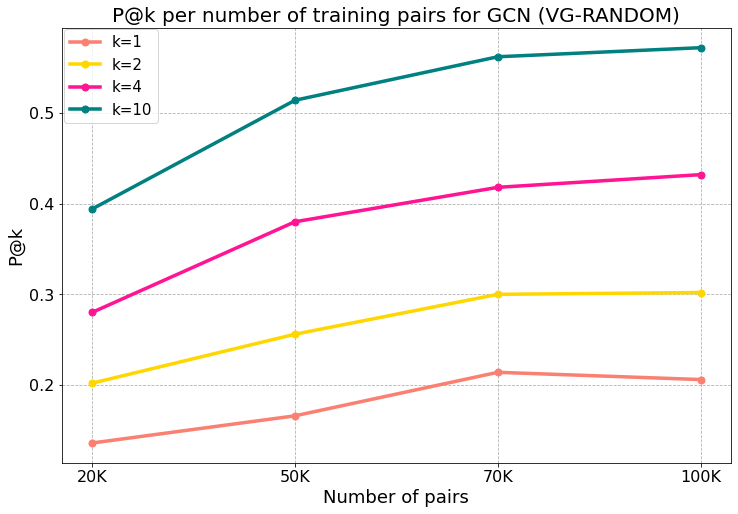

In [390]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
plt.title('P@k per number of training pairs for GCN (VG-RANDOM)', fontsize=20)
plt.plot(gcn1, color='salmon', label='k=1', marker="o", linewidth=3.5,markersize=7)
plt.plot(gcn2, color='gold', label='k=2', marker="o", linewidth=3.5,markersize=7)
plt.plot(gcn4, color='deeppink', label='k=4', marker="o", linewidth=3.5,markersize=7)
plt.plot(gcn10, color='teal', label='k=10', marker="o", linewidth=3.5,markersize=7)

plt.grid(True, linestyle='--')
plt.ylabel('P@k', fontsize=18)
plt.xlabel('Number of pairs', fontsize=18)
#locs, labels = plt.xticks()
labels = ['20K', '50K', '70K', '100K']
plt.yticks(fontsize=16)
plt.xticks(np.arange(4), labels, fontsize=16)
plt.legend(fontsize=15, loc='upper left', bbox_to_anchor=(-0.008,1.015)) # , bbox_to_anchor=(0.5,0)
plt.show()

#Kernels

με τη σειρα WL PM PA SM (και GH αλλα ειναι αθλιο οποτε ignore)

In [391]:
run_num = '2'

In [392]:
path = '/content/drive/MyDrive/data/kernel_outs/outs' + run_num + '/outs' + run_num 
sims = []
sims.append(pkl.load(open(path + '/sim500_wl.pkl', 'rb')))
sims.append(pkl.load(open(path + '/sim500_pm.pkl', 'rb')))
sims.append(pkl.load(open(path + '/sim500_pa_attr.pkl', 'rb')))
sims.append(pkl.load(open(path + '/sim500_sm_attr.pkl', 'rb')))
sims.append(pkl.load(open(path + '/sim500_gh_attr.pkl', 'rb')))

sims_rank = []
sims_rank.append(pkl.load(open(path + '/sim500_wl_rank.pkl', 'rb')))
sims_rank.append(pkl.load(open(path + '/sim500_pm_rank.pkl', 'rb')))
sims_rank.append(pkl.load(open(path + '/sim500_pa_attr_rank.pkl', 'rb')))
sims_rank.append(pkl.load(open(path + '/sim500_sm_attr_rank.pkl', 'rb')))
sims_rank.append(pkl.load(open(path + '/sim500_gh_attr_rank.pkl', 'rb')))

In [393]:
comp = []
for i in sims_rank:
  c = []
  for j in i:
    mj = max(j)
    new_j = j/mj
    c.append(new_j)

  comp.append(c)

In [394]:
emb_10_list = []
for i in range(len(comp)):
  emb_10 = find_all_similar(np.array(comp[i]))
  for idx in range(len(emb_10)):
    emb_10[idx] = [new_idxs[i][0] for i in emb_10[idx] ]
  emb_10 = [list(reversed(i)) for i in emb_10]
  emb_10_list.append(emb_10)

In [395]:
emb_10_list = [emb_10_list[i][5:] if i !=1 else emb_10_list[i] for i in range(5)]

In [396]:
all_preds = []
for j in range(len(emb_10_list)):
  preds = []
  for i in range(495):
    idx = new_idxs[i][0]
    preds.append(get_rank_untargeted_class(idx, emb_10_list[j][i], class_dict)[:10])
  all_preds.append(preds)

In [397]:
amount=495

In [398]:
hps, rbos, all_hps_list, all_rbos = score_stats([preds_gd[idx[0]][:10] for idx in new_idxs[5:]], all_preds)
hps_results['PM']=all_hps_list
rbo_results['PM']=all_rbos

---- k = 1 ----
(495, 1) (495, 1)
Hit Percentage: 0.05858585858585859
Mean RBO: 0.05858585858585859
(495, 1) (495, 1)
Hit Percentage: 0.0
Mean RBO: 0.0
(495, 1) (495, 1)
Hit Percentage: 0.048484848484848485
Mean RBO: 0.048484848484848485
(495, 1) (495, 1)
Hit Percentage: 0.050505050505050504
Mean RBO: 0.050505050505050504
(495, 1) (495, 1)
Hit Percentage: 0.020202020202020204
Mean RBO: 0.020202020202020204
---- k = 2 ----
(495, 2) (495, 2)
Hit Percentage: 0.06666666666666667
Mean RBO: 0.06262626262626263
(495, 2) (495, 2)
Hit Percentage: 0.0030303030303030303
Mean RBO: 0.0015151515151515152
(495, 2) (495, 2)
Hit Percentage: 0.048484848484848485
Mean RBO: 0.048484848484848485
(495, 2) (495, 2)
Hit Percentage: 0.06161616161616162
Mean RBO: 0.05606060606060606
(495, 2) (495, 2)
Hit Percentage: 0.020202020202020204
Mean RBO: 0.020202020202020204
---- k = 4 ----
(495, 4) (495, 4)
Hit Percentage: 0.07575757575757576
Mean RBO: 0.06927609427609427
(495, 4) (495, 4)
Hit Percentage: 0.0116161616

In [399]:
ndcg_list = []
for k in [1,2,4,10]:
  print()
  print('--------{}--------'.format(k))
  for i in range(5):
    #[preds_gd[idx[0]][:10] for idx in new_idxs], all_preds
    n = compute_ndcg([preds_gd[idx[0]][:10] for idx in new_idxs], all_preds[i], k=k)
    print(n)
    if i==1:
      ndcg_list.append([k,n])
ndcg_results['PM'] = ndcg_list
ndcg_results


--------1--------
0.5487878787878787
0.5472727272727272
0.5519191919191918
0.5506060606060605
0.5443434343434342

--------2--------
0.5712335516811861
0.5705336292457056
0.5753128791273079
0.571634454356981
0.5684710535484843

--------4--------
0.6202670061518489
0.6198590258636861
0.6219545688342437
0.6201150116932947
0.6183443474292643

--------10--------
0.8335994130140549
0.8333801789816931
0.8345406582729696
0.833805684867701
0.8326433563066403


{'GCN-20K': [[1, 0.6614000000000001],
  [2, 0.6621002117736162],
  [4, 0.6868897082420824],
  [10, 0.864844084943325]],
 'GCN-50K': [[1, 0.6961],
  [2, 0.6936000740572867],
  [4, 0.7143925766400104],
  [10, 0.8765138866582525]],
 'GCN-70K': [[1, 0.6972],
  [2, 0.7011472985552266],
  [4, 0.7148889881935738],
  [10, 0.8777872591458148]],
 'GCN-100K': [[1, 0.7163999999999999],
  [2, 0.7116764768987978],
  [4, 0.7289491491766217],
  [10, 0.8834986408129876]],
 'GAT-20K': [[1, 0.6823],
  [2, 0.6799422626549944],
  [4, 0.6974992355879608],
  [10, 0.8701009184268919]],
 'GAT-50K': [[1, 0.6897000000000001],
  [2, 0.6871571491976015],
  [4, 0.7088326011442696],
  [10, 0.8742404856972257]],
 'GAT-70K': [[1, 0.696],
  [2, 0.6963040510894375],
  [4, 0.713241085701153],
  [10, 0.8765823688666473]],
 'GAT-100K': [[1, 0.7192000000000001],
  [2, 0.7095723116797532],
  [4, 0.7176319537114989],
  [10, 0.8806589452467505]],
 'GIN-20K': [[1, 0.5967],
  [2, 0.606386262868359],
  [4, 0.6445179703491696],
  

In [400]:
ndcg_list_2 = []
for k in [1,2,4,10]:
  print()
  print('--------{}--------'.format(k))
  for i in range(len([emb_10])):
    n = compute_ndcg([preds_gd[idx[0]][:10] for idx in new_idxs], all_preds[i], k=k)
    print(n)
    ndcg_list_2.append([k,n])
ndcg_results_2['PM'] = ndcg_list_2


--------1--------
0.5487878787878787

--------2--------
0.5712335516811861

--------4--------
0.6202670061518489

--------10--------
0.8335994130140549


In [401]:
for k in [10,5,2]:
  print()
  print('--------{}--------'.format(k))
  for i in range(len(emb_10_list)):
    print(compute_ndcg_2([preds_gd[idx[0]][:10] for idx in new_idxs[5:]], all_preds[i], k=k))


--------10--------
0.47432001524298933
0.45215131131917313
0.4724828298349383
0.4726053088621417
0.4624395496042591

--------5--------
0.32064616247430633
0.2919968044612237
0.3182719062853768
0.31843019003130546
0.30529263911922894

--------2--------
0.19371381598942078
0.15971153283333625
0.1908959472195795
0.19108380513756895
0.1754915979444473


In [402]:
prec_list = []
for k in [1,2,4,10]:
  print()
  print('--------{}--------'.format(k))
  for i in range(5):
    pr = np.mean([precision_k(b,c, k=k) for b,c in zip([preds_gd[idx[0]][:10] for idx in new_idxs], all_preds[i])])
    print(pr)
    if i==1:
      prec_list.append([k, pr])
precision_results['PM']=prec_list


--------1--------
0.006060606060606061
0.0
0.012121212121212121
0.014141414141414142
0.00404040404040404

--------2--------
0.00808080808080808
0.00202020202020202
0.01616161616161616
0.01818181818181818
0.006060606060606061

--------4--------
0.012121212121212121
0.014141414141414142
0.01616161616161616
0.024242424242424242
0.006060606060606061

--------10--------
0.03232323232323232
0.026262626262626262
0.026262626262626262
0.03636363636363636
0.010101010101010102
